<a href="https://colab.research.google.com/github/matteo9910/StressDetectionBasedOnWearableSensorData/blob/main/ML_AffectiveRoad_E4_ML_DL_45sec_75OL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math
from scipy.stats import mannwhitneyu
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay, auc
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import LeaveOneGroupOut, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization

In [ ]:
# Percorso del file
file_path = "/content/drive/MyDrive/AffectiveRoad Dataset/AFFECTIVE ROAD DATASET FILE PKL/AFFECTIVEROADDATASET_E4_45SEC_75OL.csv"

# Carica il dataset
df = pd.read_csv(file_path)

# Mostra info di base
print("Shape del dataset:", df.shape)
df.head()

Shape del dataset: (7155, 25)


,HRV_MeanNN,HRV_SDNN,HRV_SDRMSSD,HRV_MinNN,HRV_VHF,HRV_S,HRV_PIP,HRV_PI,HRV_SampEn,HRV_FuzzyEn,...,subject,SCR_Peaks_N,SCR_Peaks_Amplitude_Mean,AccMag_Mean,AccMag_Std,AccMag_Max,AccMag_Skew,AccMag_Kurtosis,Temp_Std,Temp_Slope
0,710.553279,309.577566,0.725437,312.50,0.082900,300886.191651,0.655738,46.551724,3.496508,1.511412,...,Drv1,16.0,0.653195,63.675116,1.753461,69.756720,-0.060097,1.973310,0.180110,0.000053
1,751.588983,320.738585,0.688069,312.50,0.057938,326551.977356,0.576271,50.000000,2.456736,1.644480,...,Drv1,18.0,0.590595,63.838161,1.784092,69.756720,-0.250134,1.994800,0.023607,-0.000024
2,733.854167,310.560276,0.678544,312.50,0.060466,301860.408118,0.566667,53.448276,2.995732,1.625302,...,Drv1,18.0,0.556969,63.950402,1.678886,69.734938,-0.275422,2.362752,0.018575,-0.000008
3,782.924107,379.420894,0.709043,343.75,0.036566,455585.669762,0.571429,55.555556,2.120264,1.405745,...,Drv1,14.0,0.502756,64.130517,1.520972,69.734938,-0.510702,3.426006,0.020080,0.000015
4,816.332547,373.229314,0.705206,343.75,0.026310,443653.984136,0.698113,61.224490,2.639057,1.393031,...,Drv1,8.0,0.763527,64.062893,1.379024,69.734938,-0.438041,4.191910,0.020886,0.000018


In [ ]:
for col in df.columns:
  print(col)

HRV_MeanNN
HRV_SDNN
HRV_SDRMSSD
HRV_MinNN
HRV_VHF
HRV_S
HRV_PIP
HRV_PI
HRV_SampEn
HRV_FuzzyEn
HRV_MSEn
HRV_KFD
HRV_LZC
PPG_Amplitude
label
subject
SCR_Peaks_N
SCR_Peaks_Amplitude_Mean
AccMag_Mean
AccMag_Std
AccMag_Max
AccMag_Skew
AccMag_Kurtosis
Temp_Std
Temp_Slope


In [ ]:
freq_assolute = df["label"].value_counts()
freq_relative = df["label"].value_counts(normalize=True)

frequency_table = pd.DataFrame({
    'Absolut Frequency': freq_assolute,
    'Relative Frequency (%)': freq_relative.round(2)*100
})

frequency_table

,Absolut Frequency,Relative Frequency (%)
label,,
0,3706,52.0
1,3449,48.0


In [ ]:
counts = df.groupby(['subject', 'label']).size().unstack(fill_value=0)

counts['Totale'] = counts.sum(axis=1)

counts['Freq_Label_0 (%)'] = (counts[0] / counts['Totale'] * 100).round(2)
counts['Freq_Label_1 (%)'] = (counts[1] / counts['Totale'] * 100).round(2)

counts = counts.rename(columns={0: 'Baseline', 1: 'Stress'})

counts.reset_index(inplace=True)
counts

label,subject,Baseline,Stress,Totale,Freq_Label_0 (%),Freq_Label_1 (%)
0,Drv1,304,166,470,64.68,35.32
1,Drv10,411,370,781,52.62,47.38
2,Drv11,431,188,619,69.63,30.37
3,Drv12,356,189,545,65.32,34.68
4,Drv13,607,0,607,100.00,0.00
5,Drv2,304,288,592,51.35,48.65
6,Drv3,253,316,569,44.46,55.54
7,Drv4,290,260,550,52.73,47.27
8,Drv5,176,426,602,29.24,70.76
9,Drv6,180,416,596,30.20,69.80


In [ ]:
def filter_subjects_by_label1_frequency(df, label_col='label', subject_col='subject', min_label1_ratio=0.25):
    """
    Rimuove i soggetti che hanno una frequenza della classe 1 (stress) inferiore a `min_label1_ratio`.

    Parametri:
        df (DataFrame): il dataset da filtrare
        label_col (str): nome della colonna delle etichette binarie
        subject_col (str): nome della colonna dei soggetti
        min_label1_ratio (float): soglia minima per la classe 1 (es. 0.25 = 25%)

    Restituisce:
        df_filtrato (DataFrame): solo soggetti che soddisfano la condizione
    """
    # Calcolo percentuali label 1 per soggetto
    distribuzione = df.groupby(subject_col)[label_col].value_counts(normalize=True).unstack(fill_value=0)

    # Filtra soggetti con almeno min_label1_ratio per la classe 1
    soggetti_valide = distribuzione[distribuzione.get(1, 0) >= min_label1_ratio].index

    # Applica filtro al dataset originale
    df_filtrato = df[df[subject_col].isin(soggetti_valide)].copy()

    return df_filtrato

In [ ]:
df = filter_subjects_by_label1_frequency(df, min_label1_ratio=0.25)

In [ ]:
sum(df.isna().sum())

0

LOSO LOGISTIC REGRESSION

=== LOSO LOGISTIC REGRESSION ===
Samples: 6548, Features: 23, Subjects: 12

Inizio valutazione LOSO:
  Fold  1 - Drv1: F1=0.564 Acc=0.657
  Fold  2 - Drv10: F1=0.554 Acc=0.511
  Fold  3 - Drv11: F1=0.649 Acc=0.724
  Fold  4 - Drv12: F1=0.528 Acc=0.563
  Fold  5 - Drv2: F1=0.756 Acc=0.750
  Fold  6 - Drv3: F1=0.757 Acc=0.724
  Fold  7 - Drv4: F1=0.665 Acc=0.613
  Fold  8 - Drv5: F1=0.605 Acc=0.543
  Fold  9 - Drv6: F1=0.729 Acc=0.639
  Fold 10 - Drv7: F1=0.730 Acc=0.704
  Fold 11 - Drv8: F1=0.588 Acc=0.557
  Fold 12 - Drv9: F1=0.295 Acc=0.463

--------------------------------------------------
RISULTATI LOSO
--------------------------------------------------
Risultati per soggetto:
subject  n_samples  accuracy  precision  recall  f1_score
   Drv1        470    0.6574     0.5123  0.6265    0.5637
  Drv10        781    0.5109     0.4877  0.6405    0.5537
  Drv11        619    0.7237     0.5284  0.8404    0.6489
  Drv12        545    0.5633     0.4222  0.7037    0.5278
   Drv2        592  

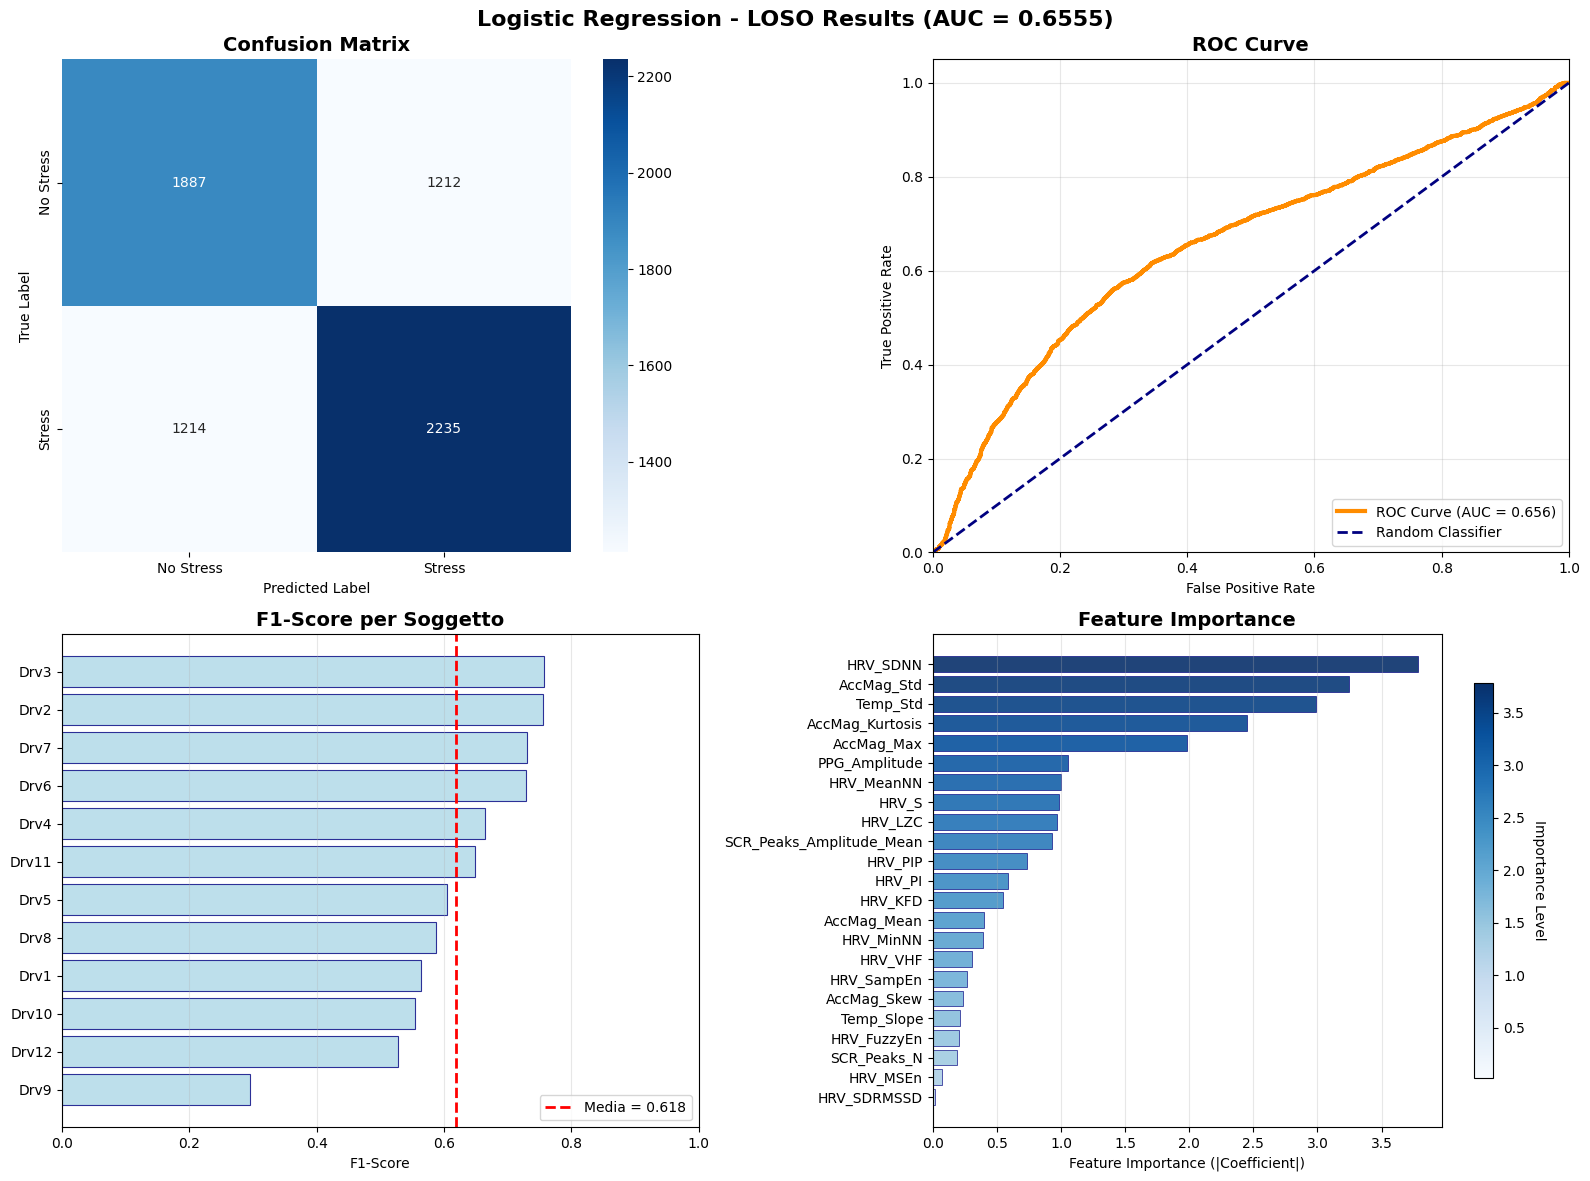


SUMMARY LOGISTIC REGRESSION LOSO
Dataset: 12 soggetti, 6548 campioni totali
F1-Score medio: 0.6182 ± 0.1303
AUC globale: 0.6555
Accuratezza globale: 0.6295
Range F1-Score: 0.2951 - 0.7566
Miglior soggetto: Drv3 (F1=0.7566)
Peggiore soggetto: Drv9 (F1=0.2951)


In [ ]:
# =============================================================================
# LOSO LOGISTIC REGRESSION CON VISUALIZZAZIONI COMPLETE
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    accuracy_score, precision_score, recall_score, f1_score
)
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# SETUP DATI E MODELLO
# =============================================================================

# Feature matrix and labels
X = df.drop(columns=['label', 'subject']).values
y = df['label'].values
groups = df['subject'].values

# Estrai nomi delle feature per visualizzazione importance
feature_names = df.drop(columns=["label", "subject"]).columns

# Setup LOSO
logo = LeaveOneGroupOut()

print("=== LOSO LOGISTIC REGRESSION ===")
print(f"Samples: {len(X)}, Features: {X.shape[1]}, Subjects: {len(np.unique(groups))}")

# =============================================================================
# CICLO LOSO CON RACCOLTA DATI COMPLETA
# =============================================================================

# Variabili per raccolta risultati
fold_results = []
all_y_true = []
all_y_pred = []
all_y_prob = []
all_subjects = []
final_model = None  # Per feature importance

print("\nInizio valutazione LOSO:")

for fold, (train_idx, test_idx) in enumerate(logo.split(X, y, groups)):
    subject = groups[test_idx[0]]
    print(f"  Fold {fold+1:2d} - {subject:3s}: ", end="")

    # Prepare data
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Skip se una sola classe nel test set
    if len(np.unique(y_test)) < 2:
        print("SKIP (una sola classe)")
        continue

    # Scaling
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Model training
    model = LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42)
    model.fit(X_train_scaled, y_train)

    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    # Metrics per fold
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"F1={f1:.3f} Acc={acc:.3f}")

    # Store results
    fold_results.append({
        'fold': fold + 1,
        'subject': subject,
        'n_samples': len(y_test),
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1
    })

    # Accumulate global data
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)
    all_y_prob.extend(y_prob)
    all_subjects.extend([subject] * len(y_test))

    # Keep final model for feature importance
    final_model = model

# =============================================================================
# RISULTATI E STATISTICHE
# =============================================================================

print(f"\n{'-'*50}")
print("RISULTATI LOSO")
print(f"{'-'*50}")

# Results per subject
results_df = pd.DataFrame(fold_results)
print("Risultati per soggetto:")
print(results_df[['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score']].to_string(
    index=False, float_format='%.4f'))

# Aggregate statistics
print(f"\nStatistiche aggregate:")
print(f"F1-Score medio:  {results_df['f1_score'].mean():.4f} ± {results_df['f1_score'].std():.4f}")
print(f"Accuracy media:  {results_df['accuracy'].mean():.4f} ± {results_df['accuracy'].std():.4f}")
print(f"Precision media: {results_df['precision'].mean():.4f} ± {results_df['precision'].std():.4f}")
print(f"Recall medio:    {results_df['recall'].mean():.4f} ± {results_df['recall'].std():.4f}")

# Global metrics
print(f"\n{'-'*50}")
print("METRICHE GLOBALI")
print(f"{'-'*50}")

# Convert to numpy arrays
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)
all_y_prob = np.array(all_y_prob)

print("Classification Report Globale:")
print(classification_report(all_y_true, all_y_pred,
                          target_names=['No Stress', 'Stress'],
                          zero_division=0))

# Confusion Matrix
cm_global = confusion_matrix(all_y_true, all_y_pred)
print(f"\nConfusion Matrix Globale:")
print(cm_global)

# ROC AUC
fpr, tpr, _ = roc_curve(all_y_true, all_y_prob)
roc_auc = auc(fpr, tpr)
print(f"AUC Globale: {roc_auc:.4f}")

all_y_true_lr = np.array(all_y_true).copy()
all_y_pred_lr = np.array(all_y_pred).copy()
all_y_prob_lr = np.array(all_y_prob).copy()
fpr_lr, tpr_lr, _ = roc_curve(all_y_true_lr, all_y_prob_lr)
auc_lr = auc(fpr_lr, tpr_lr)

f1_mean_lr = results_df['f1_score'].mean()
f1_std_lr = results_df['f1_score'].std()
acc_mean_lr = results_df['accuracy'].mean()

# =============================================================================
# VISUALIZZAZIONI COMPLETE (2x2 GRID)
# =============================================================================

print(f"\n{'-'*50}")
print("GENERAZIONE VISUALIZZAZIONI")
print(f"{'-'*50}")

# Setup figura 2x2
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'Logistic Regression - LOSO Results (AUC = {roc_auc:.4f})',
             fontsize=16, fontweight='bold')

# 1. CONFUSION MATRIX (Top Left) - Palette Blu
sns.heatmap(cm_global, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Stress', 'Stress'],
            yticklabels=['No Stress', 'Stress'],
            ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('True Label')
axes[0,0].set_xlabel('Predicted Label')

# 2. CURVA ROC (Top Right) - Colore Arancione
axes[0,1].plot(fpr, tpr, color='darkorange', lw=3,
               label=f'ROC Curve (AUC = {roc_auc:.3f})')
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
               label='Random Classifier')
axes[0,1].set_xlim([0.0, 1.0])
axes[0,1].set_ylim([0.0, 1.05])
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0,1].legend(loc="lower right")
axes[0,1].grid(True, alpha=0.3)

# 3. F1-SCORE PER SOGGETTO (Bottom Left) - Palette Blu
results_df_sorted = results_df.sort_values('f1_score', ascending=True)
bars = axes[1,0].barh(results_df_sorted['subject'],
                      results_df_sorted['f1_score'],
                      color='lightblue', alpha=0.8, edgecolor='navy', linewidth=0.8)
axes[1,0].set_xlabel('F1-Score')
axes[1,0].set_title('F1-Score per Soggetto', fontsize=14, fontweight='bold')
axes[1,0].grid(True, alpha=0.3, axis='x')

# Aggiungi linea media
mean_f1 = results_df['f1_score'].mean()
axes[1,0].axvline(x=mean_f1, color='red', linestyle='--', linewidth=2,
                  label=f'Media = {mean_f1:.3f}')
axes[1,0].legend()
axes[1,0].set_xlim(0, 1)

# 4. FEATURE IMPORTANCE (Bottom Right) - Palette Graduale
if final_model is not None:
    # Calcola importance in valore assoluto
    coefficients = np.abs(final_model.coef_[0])

    # Crea DataFrame ordinato per importance
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': coefficients
    }).sort_values(by='importance', ascending=True)

    # Plot con colori graduali basati sull'importanza
    colors = plt.cm.Blues(np.linspace(0.3, 1.0, len(importance_df)))

    bars = axes[1,1].barh(range(len(importance_df)),
                          importance_df['importance'],
                          color=colors, alpha=0.9, edgecolor='navy', linewidth=0.5)

    # Configura assi
    axes[1,1].set_yticks(range(len(importance_df)))
    axes[1,1].set_yticklabels(importance_df['feature'], fontsize=10)
    axes[1,1].set_xlabel('Feature Importance (|Coefficient|)')
    axes[1,1].set_title('Feature Importance', fontsize=14, fontweight='bold')
    axes[1,1].grid(True, alpha=0.3, axis='x')

    # Aggiungi colorbar per scala importance
    sm = plt.cm.ScalarMappable(cmap='Blues',
                               norm=plt.Normalize(vmin=importance_df['importance'].min(),
                                                vmax=importance_df['importance'].max()))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=axes[1,1], shrink=0.8)
    cbar.set_label('Importance Level', rotation=270, labelpad=15)

    print(f"Top 5 features più importanti:")
    top_features = importance_df.tail(5)[['feature', 'importance']]
    for _, row in top_features.iterrows():
        print(f"  {row['feature']}: {row['importance']:.4f}")

else:
    axes[1,1].text(0.5, 0.5, 'Feature Importance\nNon Disponibile',
                   ha='center', va='center', fontsize=12,
                   transform=axes[1,1].transAxes)
    axes[1,1].set_title('Feature Importance', fontsize=14, fontweight='bold')

# Adjust layout
plt.tight_layout()
plt.show()

# =============================================================================
# SUMMARY FINALE
# =============================================================================

print(f"\n{'='*60}")
print("SUMMARY LOGISTIC REGRESSION LOSO")
print(f"{'='*60}")
print(f"Dataset: {len(np.unique(groups))} soggetti, {len(all_y_true)} campioni totali")
print(f"F1-Score medio: {results_df['f1_score'].mean():.4f} ± {results_df['f1_score'].std():.4f}")
print(f"AUC globale: {roc_auc:.4f}")
print(f"Accuratezza globale: {accuracy_score(all_y_true, all_y_pred):.4f}")

# Range performance
print(f"Range F1-Score: {results_df['f1_score'].min():.4f} - {results_df['f1_score'].max():.4f}")
best_subject = results_df.loc[results_df['f1_score'].idxmax(), 'subject']
worst_subject = results_df.loc[results_df['f1_score'].idxmin(), 'subject']
print(f"Miglior soggetto: {best_subject} (F1={results_df['f1_score'].max():.4f})")
print(f"Peggiore soggetto: {worst_subject} (F1={results_df['f1_score'].min():.4f})")
print(f"{'='*60}")

RANDOM FOREST

=== LOSO RANDOM FOREST ===
Samples: 6548, Features: 23, Subjects: 12

Inizio valutazione LOSO:
  Fold  1 - Drv1: F1=0.535 Acc=0.579
  Fold  2 - Drv10: F1=0.588 Acc=0.606
  Fold  3 - Drv11: F1=0.515 Acc=0.641
  Fold  4 - Drv12: F1=0.569 Acc=0.602
  Fold  5 - Drv2: F1=0.676 Acc=0.682
  Fold  6 - Drv3: F1=0.757 Acc=0.728
  Fold  7 - Drv4: F1=0.647 Acc=0.635
  Fold  8 - Drv5: F1=0.608 Acc=0.563
  Fold  9 - Drv6: F1=0.620 Acc=0.555
  Fold 10 - Drv7: F1=0.644 Acc=0.646
  Fold 11 - Drv8: F1=0.591 Acc=0.560
  Fold 12 - Drv9: F1=0.684 Acc=0.700

--------------------------------------------------
RISULTATI LOSO
--------------------------------------------------
Risultati per soggetto:
subject  n_samples  accuracy  precision  recall  f1_score
   Drv1        470    0.5787     0.4385  0.6867    0.5352
  Drv10        781    0.6056     0.5820  0.5946    0.5882
  Drv11        619    0.6414     0.4370  0.6277    0.5153
  Drv12        545    0.6018     0.4554  0.7566    0.5686
   Drv2        592    0.68

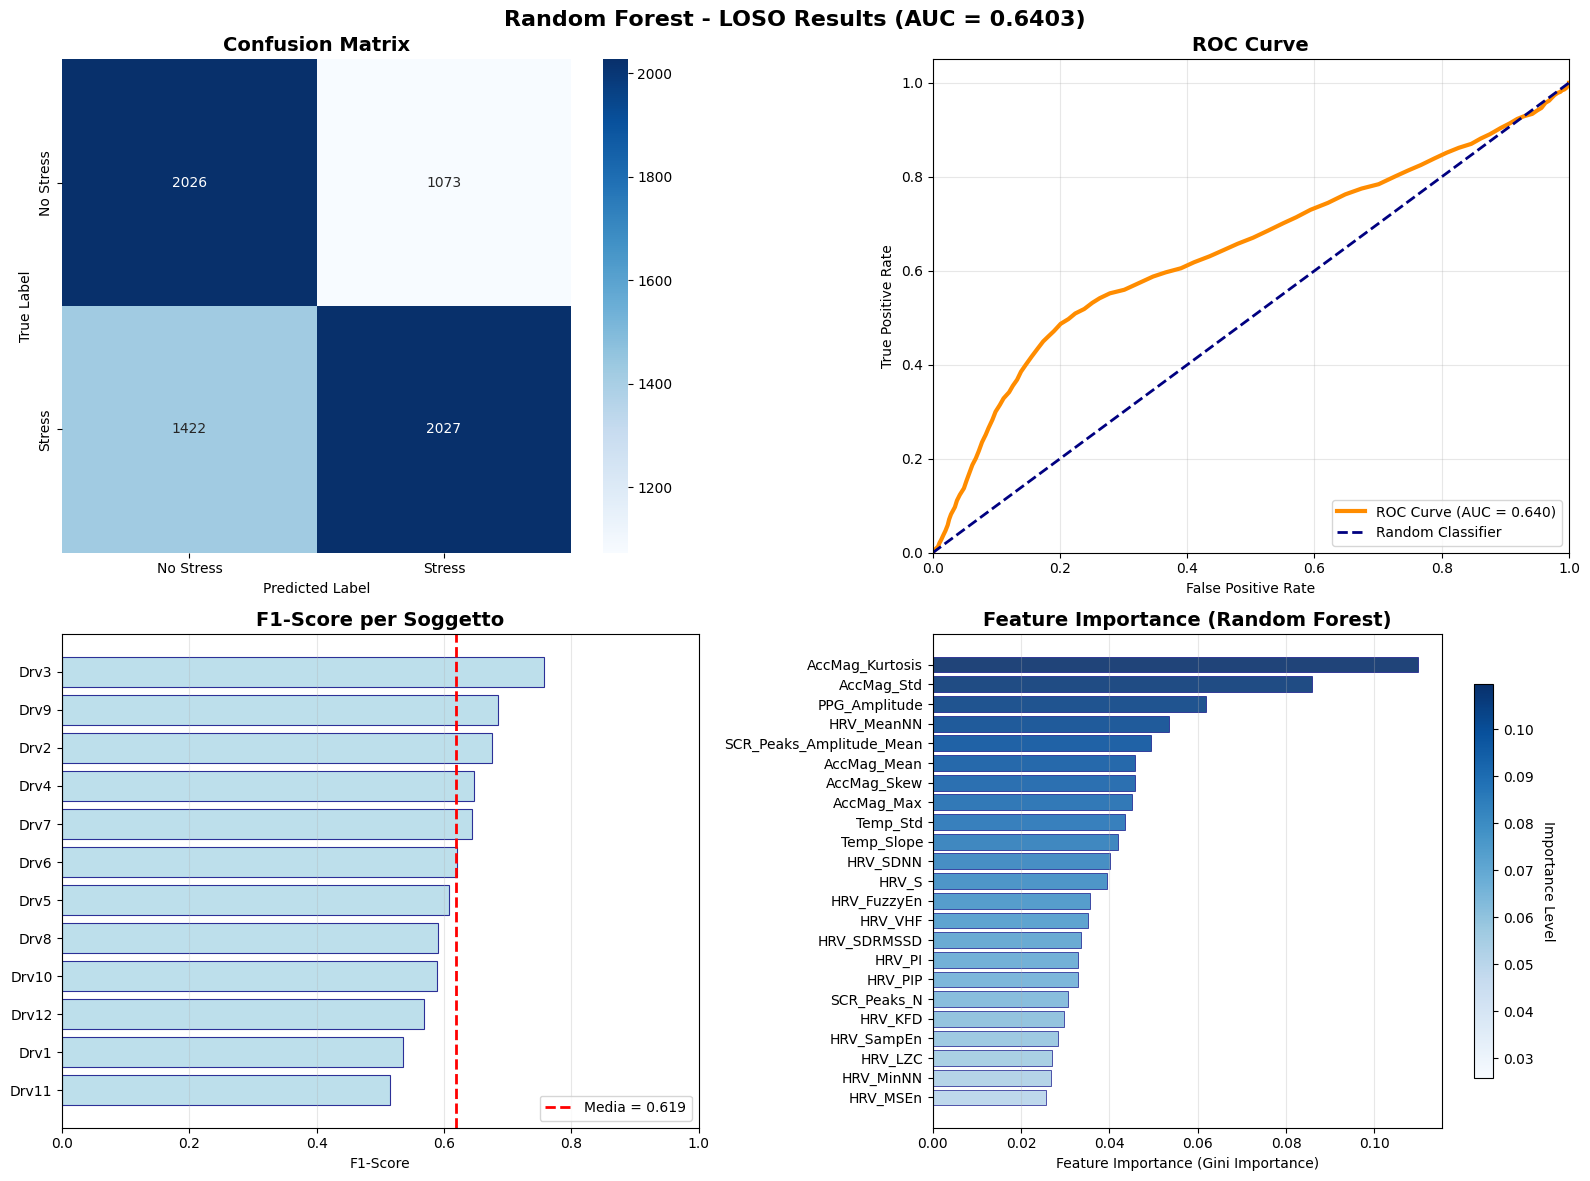


SUMMARY RANDOM FOREST LOSO
Dataset: 12 soggetti, 6548 campioni totali
F1-Score medio: 0.6195 ± 0.0674
AUC globale: 0.6403
Accuratezza globale: 0.6190
Range F1-Score: 0.5153 - 0.7567
Miglior soggetto: Drv3 (F1=0.7567)
Peggiore soggetto: Drv11 (F1=0.5153)

Parametri Random Forest:
N. estimatori: 100
Profondità massima: None
Features per split: sqrt
Criterio: gini


In [ ]:
# =============================================================================
# LOSO RANDOM FOREST CON VISUALIZZAZIONI COMPLETE
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    accuracy_score, precision_score, recall_score, f1_score
)
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# SETUP DATI E MODELLO
# =============================================================================

# Feature matrix and labels
X = df.drop(columns=['label', 'subject']).values
y = df['label'].values
groups = df['subject'].values

# Estrai nomi delle feature per visualizzazione importance
feature_names = df.drop(columns=["label", "subject"]).columns

# Setup LOSO
logo = LeaveOneGroupOut()

print("=== LOSO RANDOM FOREST ===")
print(f"Samples: {len(X)}, Features: {X.shape[1]}, Subjects: {len(np.unique(groups))}")

# =============================================================================
# CICLO LOSO CON RACCOLTA DATI COMPLETA
# =============================================================================

# Variabili per raccolta risultati
fold_results = []
all_y_true = []
all_y_pred = []
all_y_prob = []
all_subjects = []
final_model = None  # Per feature importance

print("\nInizio valutazione LOSO:")

for fold, (train_idx, test_idx) in enumerate(logo.split(X, y, groups)):
    subject = groups[test_idx[0]]
    print(f"  Fold {fold+1:2d} - {subject:3s}: ", end="")

    # Prepare data
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Skip se una sola classe nel test set
    if len(np.unique(y_test)) < 2:
        print("SKIP (una sola classe)")
        continue

    # Model training
    model = RandomForestClassifier(
        n_estimators=100,
        criterion='gini',
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='sqrt',
        class_weight='balanced',
        random_state=42,
        n_jobs=-1  # Parallelizzazione per velocità
    )

    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Metrics per fold
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"F1={f1:.3f} Acc={acc:.3f}")

    # Store results
    fold_results.append({
        'fold': fold + 1,
        'subject': subject,
        'n_samples': len(y_test),
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1
    })

    # Accumulate global data
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)
    all_y_prob.extend(y_prob)
    all_subjects.extend([subject] * len(y_test))

    # Keep final model for feature importance
    final_model = model

# =============================================================================
# RISULTATI E STATISTICHE
# =============================================================================

print(f"\n{'-'*50}")
print("RISULTATI LOSO")
print(f"{'-'*50}")

# Results per subject
results_df = pd.DataFrame(fold_results)
print("Risultati per soggetto:")
print(results_df[['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score']].to_string(
    index=False, float_format='%.4f'))

# Aggregate statistics
print(f"\nStatistiche aggregate:")
print(f"F1-Score medio:  {results_df['f1_score'].mean():.4f} ± {results_df['f1_score'].std():.4f}")
print(f"Accuracy media:  {results_df['accuracy'].mean():.4f} ± {results_df['accuracy'].std():.4f}")
print(f"Precision media: {results_df['precision'].mean():.4f} ± {results_df['precision'].std():.4f}")
print(f"Recall medio:    {results_df['recall'].mean():.4f} ± {results_df['recall'].std():.4f}")

# Global metrics
print(f"\n{'-'*50}")
print("METRICHE GLOBALI")
print(f"{'-'*50}")

# Convert to numpy arrays
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)
all_y_prob = np.array(all_y_prob)

print("Classification Report Globale:")
print(classification_report(all_y_true, all_y_pred,
                          target_names=['No Stress', 'Stress'],
                          zero_division=0))

# Confusion Matrix
cm_global = confusion_matrix(all_y_true, all_y_pred)
print(f"\nConfusion Matrix Globale:")
print(cm_global)

# ROC AUC
fpr, tpr, _ = roc_curve(all_y_true, all_y_prob)
roc_auc = auc(fpr, tpr)
print(f"AUC Globale: {roc_auc:.4f}")

all_y_true_rf = np.array(all_y_true).copy()
all_y_pred_rf = np.array(all_y_pred).copy()
all_y_prob_rf = np.array(all_y_prob).copy()
fpr_rf, tpr_rf, _ = roc_curve(all_y_true_rf, all_y_prob_rf)
auc_rf = auc(fpr_rf, tpr_rf)

f1_mean_rf = results_df['f1_score'].mean()
f1_std_rf = results_df['f1_score'].std()
acc_mean_rf = results_df['accuracy'].mean()

# =============================================================================
# VISUALIZZAZIONI COMPLETE (2x2 GRID)
# =============================================================================

print(f"\n{'-'*50}")
print("GENERAZIONE VISUALIZZAZIONI")
print(f"{'-'*50}")

# Setup figura 2x2
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'Random Forest - LOSO Results (AUC = {roc_auc:.4f})',
             fontsize=16, fontweight='bold')

# 1. CONFUSION MATRIX (Top Left) - Palette Blu
sns.heatmap(cm_global, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Stress', 'Stress'],
            yticklabels=['No Stress', 'Stress'],
            ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('True Label')
axes[0,0].set_xlabel('Predicted Label')

# 2. CURVA ROC (Top Right) - Colore Arancione
axes[0,1].plot(fpr, tpr, color='darkorange', lw=3,
               label=f'ROC Curve (AUC = {roc_auc:.3f})')
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
               label='Random Classifier')
axes[0,1].set_xlim([0.0, 1.0])
axes[0,1].set_ylim([0.0, 1.05])
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0,1].legend(loc="lower right")
axes[0,1].grid(True, alpha=0.3)

# 3. F1-SCORE PER SOGGETTO (Bottom Left) - Palette Blu
results_df_sorted = results_df.sort_values('f1_score', ascending=True)
bars = axes[1,0].barh(results_df_sorted['subject'],
                      results_df_sorted['f1_score'],
                      color='lightblue', alpha=0.8, edgecolor='navy', linewidth=0.8)
axes[1,0].set_xlabel('F1-Score')
axes[1,0].set_title('F1-Score per Soggetto', fontsize=14, fontweight='bold')
axes[1,0].grid(True, alpha=0.3, axis='x')

# Aggiungi linea media
mean_f1 = results_df['f1_score'].mean()
axes[1,0].axvline(x=mean_f1, color='red', linestyle='--', linewidth=2,
                  label=f'Media = {mean_f1:.3f}')
axes[1,0].legend()
axes[1,0].set_xlim(0, 1)

# 4. FEATURE IMPORTANCE (Bottom Right) - Random Forest Importance
if final_model is not None:
    # Calcola feature importance dal Random Forest
    feature_importance = final_model.feature_importances_

    # Crea DataFrame ordinato per importance
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values(by='importance', ascending=True)

    # Plot con colori graduali basati sull'importanza
    colors = plt.cm.Blues(np.linspace(0.3, 1.0, len(importance_df)))

    bars = axes[1,1].barh(range(len(importance_df)),
                          importance_df['importance'],
                          color=colors, alpha=0.9, edgecolor='navy', linewidth=0.5)

    # Configura assi
    axes[1,1].set_yticks(range(len(importance_df)))
    axes[1,1].set_yticklabels(importance_df['feature'], fontsize=10)
    axes[1,1].set_xlabel('Feature Importance (Gini Importance)')
    axes[1,1].set_title('Feature Importance (Random Forest)', fontsize=14, fontweight='bold')
    axes[1,1].grid(True, alpha=0.3, axis='x')

    # Aggiungi colorbar per scala importance
    sm = plt.cm.ScalarMappable(cmap='Blues',
                               norm=plt.Normalize(vmin=importance_df['importance'].min(),
                                                vmax=importance_df['importance'].max()))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=axes[1,1], shrink=0.8)
    cbar.set_label('Importance Level', rotation=270, labelpad=15)

    print(f"Top 5 features più importanti:")
    top_features = importance_df.tail(5)[['feature', 'importance']]
    for _, row in top_features.iterrows():
        print(f"  {row['feature']}: {row['importance']:.4f}")

    # Statistiche feature importance
    print(f"\nStatistiche Feature Importance:")
    print(f"Feature più importante: {importance_df.iloc[-1]['feature']} ({importance_df.iloc[-1]['importance']:.4f})")
    print(f"Importanza media: {feature_importance.mean():.4f}")
    print(f"Features con importanza > media: {np.sum(feature_importance > feature_importance.mean())}")

else:
    axes[1,1].text(0.5, 0.5, 'Feature Importance\nNon Disponibile',
                   ha='center', va='center', fontsize=12,
                   transform=axes[1,1].transAxes)
    axes[1,1].set_title('Feature Importance', fontsize=14, fontweight='bold')

# Adjust layout
plt.tight_layout()
plt.show()

# =============================================================================
# SUMMARY FINALE
# =============================================================================

print(f"\n{'='*60}")
print("SUMMARY RANDOM FOREST LOSO")
print(f"{'='*60}")
print(f"Dataset: {len(np.unique(groups))} soggetti, {len(all_y_true)} campioni totali")
print(f"F1-Score medio: {results_df['f1_score'].mean():.4f} ± {results_df['f1_score'].std():.4f}")
print(f"AUC globale: {roc_auc:.4f}")
print(f"Accuratezza globale: {accuracy_score(all_y_true, all_y_pred):.4f}")

# Range performance
print(f"Range F1-Score: {results_df['f1_score'].min():.4f} - {results_df['f1_score'].max():.4f}")
best_subject = results_df.loc[results_df['f1_score'].idxmax(), 'subject']
worst_subject = results_df.loc[results_df['f1_score'].idxmin(), 'subject']
print(f"Miglior soggetto: {best_subject} (F1={results_df['f1_score'].max():.4f})")
print(f"Peggiore soggetto: {worst_subject} (F1={results_df['f1_score'].min():.4f})")

# Informazioni modello
if final_model is not None:
    print(f"\nParametri Random Forest:")
    print(f"N. estimatori: {final_model.n_estimators}")
    print(f"Profondità massima: {final_model.max_depth}")
    print(f"Features per split: {final_model.max_features}")
    print(f"Criterio: {final_model.criterion}")

print(f"{'='*60}")

GRADIENT BOOSTING CLASSIFIER

=== LOSO GRADIENT BOOSTING ===
Samples: 6548, Features: 23, Subjects: 12

Inizio valutazione LOSO:
  Fold  1 - Drv1: F1=0.523 Acc=0.600
  Fold  2 - Drv10: F1=0.596 Acc=0.581
  Fold  3 - Drv11: F1=0.577 Acc=0.679
  Fold  4 - Drv12: F1=0.521 Acc=0.574
  Fold  5 - Drv2: F1=0.624 Acc=0.622
  Fold  6 - Drv3: F1=0.775 Acc=0.738
  Fold  7 - Drv4: F1=0.674 Acc=0.667
  Fold  8 - Drv5: F1=0.630 Acc=0.580
  Fold  9 - Drv6: F1=0.615 Acc=0.535
  Fold 10 - Drv7: F1=0.591 Acc=0.602
  Fold 11 - Drv8: F1=0.553 Acc=0.532
  Fold 12 - Drv9: F1=0.240 Acc=0.287

--------------------------------------------------
RISULTATI LOSO
--------------------------------------------------
Risultati per soggetto:
subject  n_samples  accuracy  precision  recall  f1_score
   Drv1        470    0.6000     0.4518  0.6205    0.5228
  Drv10        781    0.5813     0.5490  0.6514    0.5958
  Drv11        619    0.6785     0.4806  0.7234    0.5775
  Drv12        545    0.5743     0.4271  0.6667    0.5207
   Drv2        592    

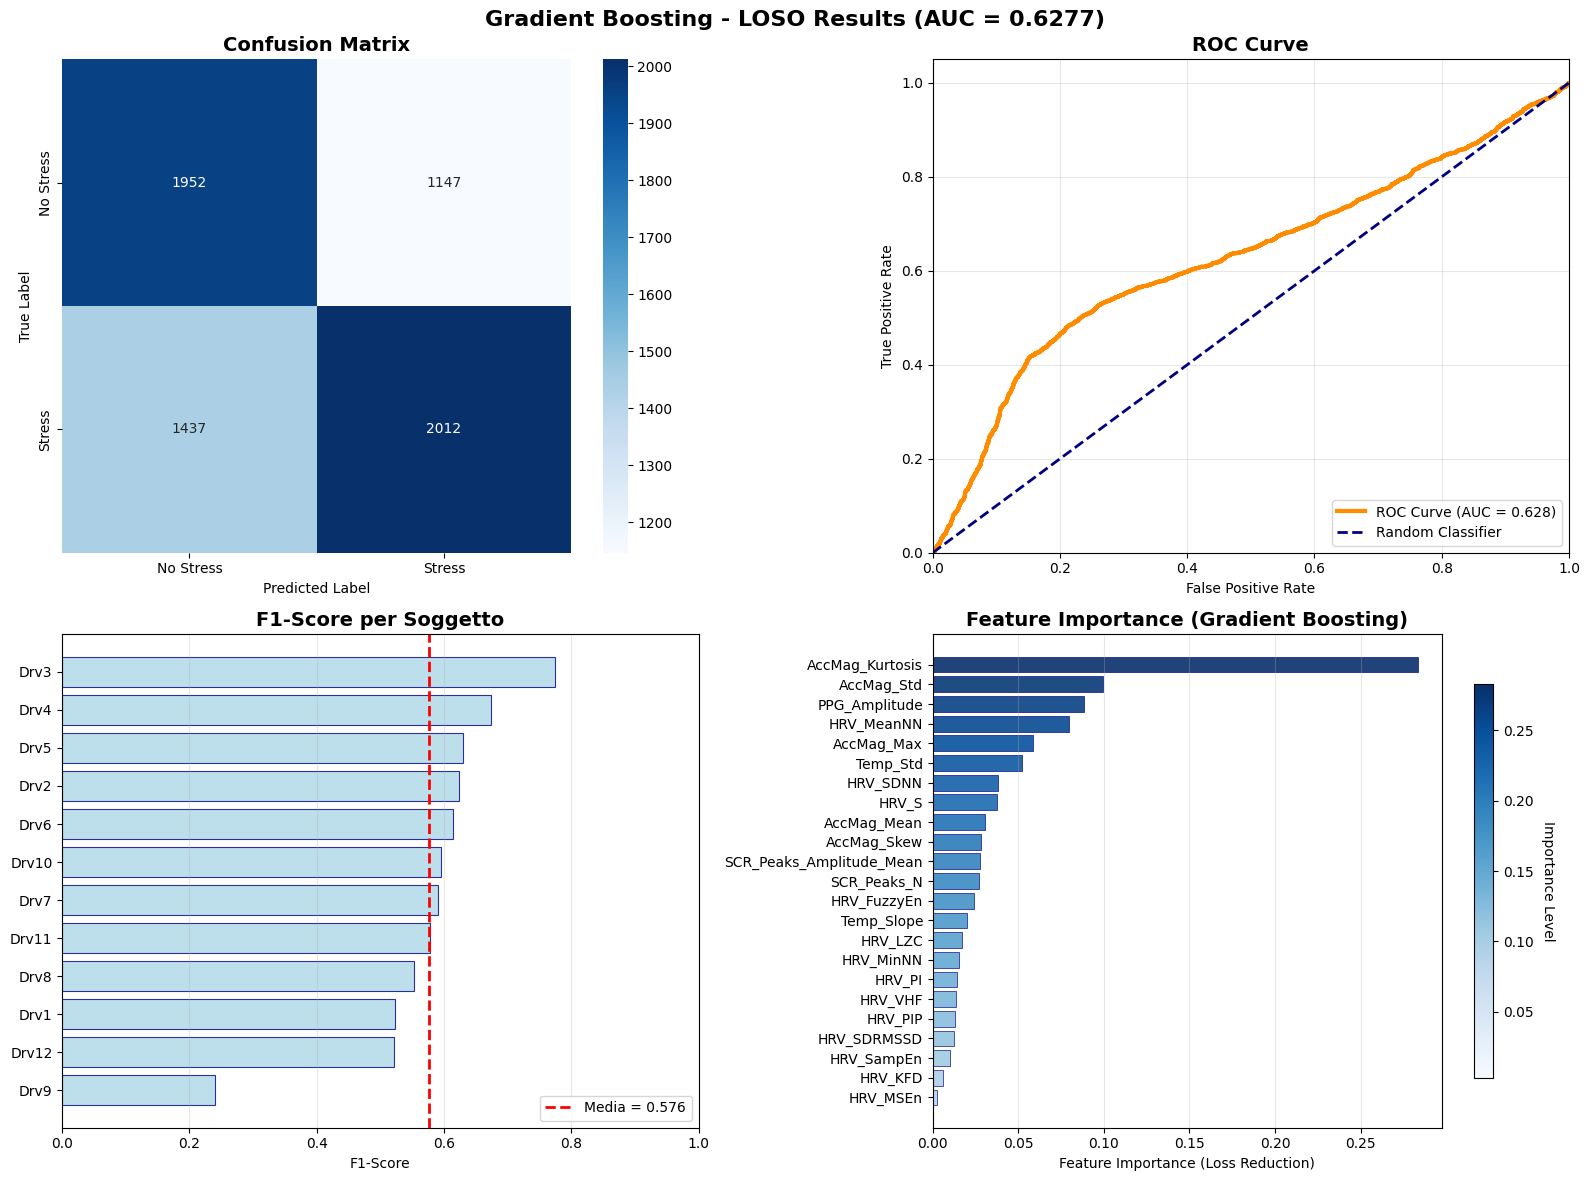


SUMMARY GRADIENT BOOSTING LOSO
Dataset: 12 soggetti, 6548 campioni totali
F1-Score medio: 0.5765 ± 0.1263
AUC globale: 0.6277
Accuratezza globale: 0.6054
Range F1-Score: 0.2400 - 0.7746
Miglior soggetto: Drv3 (F1=0.7746)
Peggiore soggetto: Drv9 (F1=0.2400)

Parametri Gradient Boosting:
N. estimatori: 100
Learning rate: 0.1
Profondità massima: 3
Subsample: 0.8
N. estimatori effettivi: 100
Training score finale: 0.9771


In [ ]:
# =============================================================================
# LOSO GRADIENT BOOSTING CON VISUALIZZAZIONI COMPLETE
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    accuracy_score, precision_score, recall_score, f1_score
)
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# SETUP DATI E MODELLO
# =============================================================================

# Feature matrix and labels
X = df.drop(columns=['label', 'subject']).values
y = df['label'].values
groups = df['subject'].values

# Estrai nomi delle feature per visualizzazione importance
feature_names = df.drop(columns=["label", "subject"]).columns

# Setup LOSO
logo = LeaveOneGroupOut()

print("=== LOSO GRADIENT BOOSTING ===")
print(f"Samples: {len(X)}, Features: {X.shape[1]}, Subjects: {len(np.unique(groups))}")

# =============================================================================
# CICLO LOSO CON RACCOLTA DATI COMPLETA
# =============================================================================

# Variabili per raccolta risultati
fold_results = []
all_y_true = []
all_y_pred = []
all_y_prob = []
all_subjects = []
final_model = None  # Per feature importance

print("\nInizio valutazione LOSO:")

for fold, (train_idx, test_idx) in enumerate(logo.split(X, y, groups)):
    subject = groups[test_idx[0]]
    print(f"  Fold {fold+1:2d} - {subject:3s}: ", end="")

    # Prepare data
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Skip se una sola classe nel test set
    if len(np.unique(y_test)) < 2:
        print("SKIP (una sola classe)")
        continue

    # Scaling (importante per Gradient Boosting)
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Model training
    model = GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        subsample=0.8,
        max_features='sqrt',
        random_state=42,
        validation_fraction=0.1,
        n_iter_no_change=5,
        tol=1e-4
    )

    model.fit(X_train_scaled, y_train)

    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    # Metrics per fold
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"F1={f1:.3f} Acc={acc:.3f}")

    # Store results
    fold_results.append({
        'fold': fold + 1,
        'subject': subject,
        'n_samples': len(y_test),
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1
    })

    # Accumulate global data
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)
    all_y_prob.extend(y_prob)
    all_subjects.extend([subject] * len(y_test))

    # Keep final model for feature importance
    final_model = model

# =============================================================================
# RISULTATI E STATISTICHE
# =============================================================================

print(f"\n{'-'*50}")
print("RISULTATI LOSO")
print(f"{'-'*50}")

# Results per subject
results_df = pd.DataFrame(fold_results)
print("Risultati per soggetto:")
print(results_df[['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score']].to_string(
    index=False, float_format='%.4f'))

# Aggregate statistics
print(f"\nStatistiche aggregate:")
print(f"F1-Score medio:  {results_df['f1_score'].mean():.4f} ± {results_df['f1_score'].std():.4f}")
print(f"Accuracy media:  {results_df['accuracy'].mean():.4f} ± {results_df['accuracy'].std():.4f}")
print(f"Precision media: {results_df['precision'].mean():.4f} ± {results_df['precision'].std():.4f}")
print(f"Recall medio:    {results_df['recall'].mean():.4f} ± {results_df['recall'].std():.4f}")

# Global metrics
print(f"\n{'-'*50}")
print("METRICHE GLOBALI")
print(f"{'-'*50}")

# Convert to numpy arrays
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)
all_y_prob = np.array(all_y_prob)

print("Classification Report Globale:")
print(classification_report(all_y_true, all_y_pred,
                          target_names=['No Stress', 'Stress'],
                          zero_division=0))

# Confusion Matrix
cm_global = confusion_matrix(all_y_true, all_y_pred)
print(f"\nConfusion Matrix Globale:")
print(cm_global)

# ROC AUC
fpr, tpr, _ = roc_curve(all_y_true, all_y_prob)
roc_auc = auc(fpr, tpr)
print(f"AUC Globale: {roc_auc:.4f}")

all_y_true_gb = np.array(all_y_true).copy()
all_y_pred_gb = np.array(all_y_pred).copy()
all_y_prob_gb = np.array(all_y_prob).copy()
fpr_gb, tpr_gb, _ = roc_curve(all_y_true_gb, all_y_prob_gb)
auc_gb = auc(fpr_gb, tpr_gb)

f1_mean_gb = results_df['f1_score'].mean()
f1_std_gb = results_df['f1_score'].std()
acc_mean_gb = results_df['accuracy'].mean()

# =============================================================================
# VISUALIZZAZIONI COMPLETE (2x2 GRID)
# =============================================================================

print(f"\n{'-'*50}")
print("GENERAZIONE VISUALIZZAZIONI")
print(f"{'-'*50}")

# Setup figura 2x2
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'Gradient Boosting - LOSO Results (AUC = {roc_auc:.4f})',
             fontsize=16, fontweight='bold')

# 1. CONFUSION MATRIX (Top Left) - Palette Blu
sns.heatmap(cm_global, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Stress', 'Stress'],
            yticklabels=['No Stress', 'Stress'],
            ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('True Label')
axes[0,0].set_xlabel('Predicted Label')

# 2. CURVA ROC (Top Right) - Colore Arancione
axes[0,1].plot(fpr, tpr, color='darkorange', lw=3,
               label=f'ROC Curve (AUC = {roc_auc:.3f})')
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
               label='Random Classifier')
axes[0,1].set_xlim([0.0, 1.0])
axes[0,1].set_ylim([0.0, 1.05])
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0,1].legend(loc="lower right")
axes[0,1].grid(True, alpha=0.3)

# 3. F1-SCORE PER SOGGETTO (Bottom Left) - Palette Blu
results_df_sorted = results_df.sort_values('f1_score', ascending=True)
bars = axes[1,0].barh(results_df_sorted['subject'],
                      results_df_sorted['f1_score'],
                      color='lightblue', alpha=0.8, edgecolor='navy', linewidth=0.8)
axes[1,0].set_xlabel('F1-Score')
axes[1,0].set_title('F1-Score per Soggetto', fontsize=14, fontweight='bold')
axes[1,0].grid(True, alpha=0.3, axis='x')

# Aggiungi linea media
mean_f1 = results_df['f1_score'].mean()
axes[1,0].axvline(x=mean_f1, color='red', linestyle='--', linewidth=2,
                  label=f'Media = {mean_f1:.3f}')
axes[1,0].legend()
axes[1,0].set_xlim(0, 1)

# 4. FEATURE IMPORTANCE (Bottom Right) - Gradient Boosting Importance
if final_model is not None:
    # Calcola feature importance dal Gradient Boosting
    feature_importance = final_model.feature_importances_

    # Crea DataFrame ordinato per importance
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values(by='importance', ascending=True)

    # Plot con colori graduali basati sull'importanza
    colors = plt.cm.Blues(np.linspace(0.3, 1.0, len(importance_df)))

    bars = axes[1,1].barh(range(len(importance_df)),
                          importance_df['importance'],
                          color=colors, alpha=0.9, edgecolor='navy', linewidth=0.5)

    # Configura assi
    axes[1,1].set_yticks(range(len(importance_df)))
    axes[1,1].set_yticklabels(importance_df['feature'], fontsize=10)
    axes[1,1].set_xlabel('Feature Importance (Loss Reduction)')
    axes[1,1].set_title('Feature Importance (Gradient Boosting)', fontsize=14, fontweight='bold')
    axes[1,1].grid(True, alpha=0.3, axis='x')

    # Aggiungi colorbar per scala importance
    sm = plt.cm.ScalarMappable(cmap='Blues',
                               norm=plt.Normalize(vmin=importance_df['importance'].min(),
                                                vmax=importance_df['importance'].max()))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=axes[1,1], shrink=0.8)
    cbar.set_label('Importance Level', rotation=270, labelpad=15)

    print(f"Top 5 features più importanti:")
    top_features = importance_df.tail(5)[['feature', 'importance']]
    for _, row in top_features.iterrows():
        print(f"  {row['feature']}: {row['importance']:.4f}")

    # Statistiche feature importance
    print(f"\nStatistiche Feature Importance:")
    print(f"Feature più importante: {importance_df.iloc[-1]['feature']} ({importance_df.iloc[-1]['importance']:.4f})")
    print(f"Importanza media: {feature_importance.mean():.4f}")
    print(f"Features con importanza > media: {np.sum(feature_importance > feature_importance.mean())}")

else:
    axes[1,1].text(0.5, 0.5, 'Feature Importance\nNon Disponibile',
                   ha='center', va='center', fontsize=12,
                   transform=axes[1,1].transAxes)
    axes[1,1].set_title('Feature Importance', fontsize=14, fontweight='bold')

# Adjust layout
plt.tight_layout()
plt.show()

# =============================================================================
# SUMMARY FINALE
# =============================================================================

print(f"\n{'='*60}")
print("SUMMARY GRADIENT BOOSTING LOSO")
print(f"{'='*60}")
print(f"Dataset: {len(np.unique(groups))} soggetti, {len(all_y_true)} campioni totali")
print(f"F1-Score medio: {results_df['f1_score'].mean():.4f} ± {results_df['f1_score'].std():.4f}")
print(f"AUC globale: {roc_auc:.4f}")
print(f"Accuratezza globale: {accuracy_score(all_y_true, all_y_pred):.4f}")

# Range performance
print(f"Range F1-Score: {results_df['f1_score'].min():.4f} - {results_df['f1_score'].max():.4f}")
best_subject = results_df.loc[results_df['f1_score'].idxmax(), 'subject']
worst_subject = results_df.loc[results_df['f1_score'].idxmin(), 'subject']
print(f"Miglior soggetto: {best_subject} (F1={results_df['f1_score'].max():.4f})")
print(f"Peggiore soggetto: {worst_subject} (F1={results_df['f1_score'].min():.4f})")

# Informazioni modello
if final_model is not None:
    print(f"\nParametri Gradient Boosting:")
    print(f"N. estimatori: {final_model.n_estimators}")
    print(f"Learning rate: {final_model.learning_rate}")
    print(f"Profondità massima: {final_model.max_depth}")
    print(f"Subsample: {final_model.subsample}")
    print(f"N. estimatori effettivi: {final_model.n_estimators_}")

    # Informazioni training
    if hasattr(final_model, 'train_score_'):
        print(f"Training score finale: {final_model.train_score_[-1]:.4f}")
    if hasattr(final_model, 'validation_scores_'):
        print(f"Validation score finale: {final_model.validation_scores_[-1]:.4f}")

print(f"{'='*60}")

XGB CLASSIFIER

=== LOSO XGBOOST ===
Samples: 6548, Features: 23, Subjects: 12

Inizio valutazione LOSO:
  Fold  1 - Drv1: F1=0.541 Acc=0.611
  Fold  2 - Drv10: F1=0.656 Acc=0.611
  Fold  3 - Drv11: F1=0.543 Acc=0.654
  Fold  4 - Drv12: F1=0.564 Acc=0.611
  Fold  5 - Drv2: F1=0.625 Acc=0.622
  Fold  6 - Drv3: F1=0.777 Acc=0.745
  Fold  7 - Drv4: F1=0.676 Acc=0.671
  Fold  8 - Drv5: F1=0.630 Acc=0.580
  Fold  9 - Drv6: F1=0.622 Acc=0.552
  Fold 10 - Drv7: F1=0.646 Acc=0.644
  Fold 11 - Drv8: F1=0.558 Acc=0.538
  Fold 12 - Drv9: F1=0.415 Acc=0.400

--------------------------------------------------
RISULTATI LOSO
--------------------------------------------------
Risultati per soggetto:
subject  n_samples  accuracy  precision  recall  f1_score
   Drv1        470    0.6106     0.4635  0.6506    0.5414
  Drv10        781    0.6108     0.5642  0.7838    0.6561
  Drv11        619    0.6543     0.4536  0.6755    0.5427
  Drv12        545    0.6110     0.4613  0.7249    0.5638
   Drv2        592    0.6216    

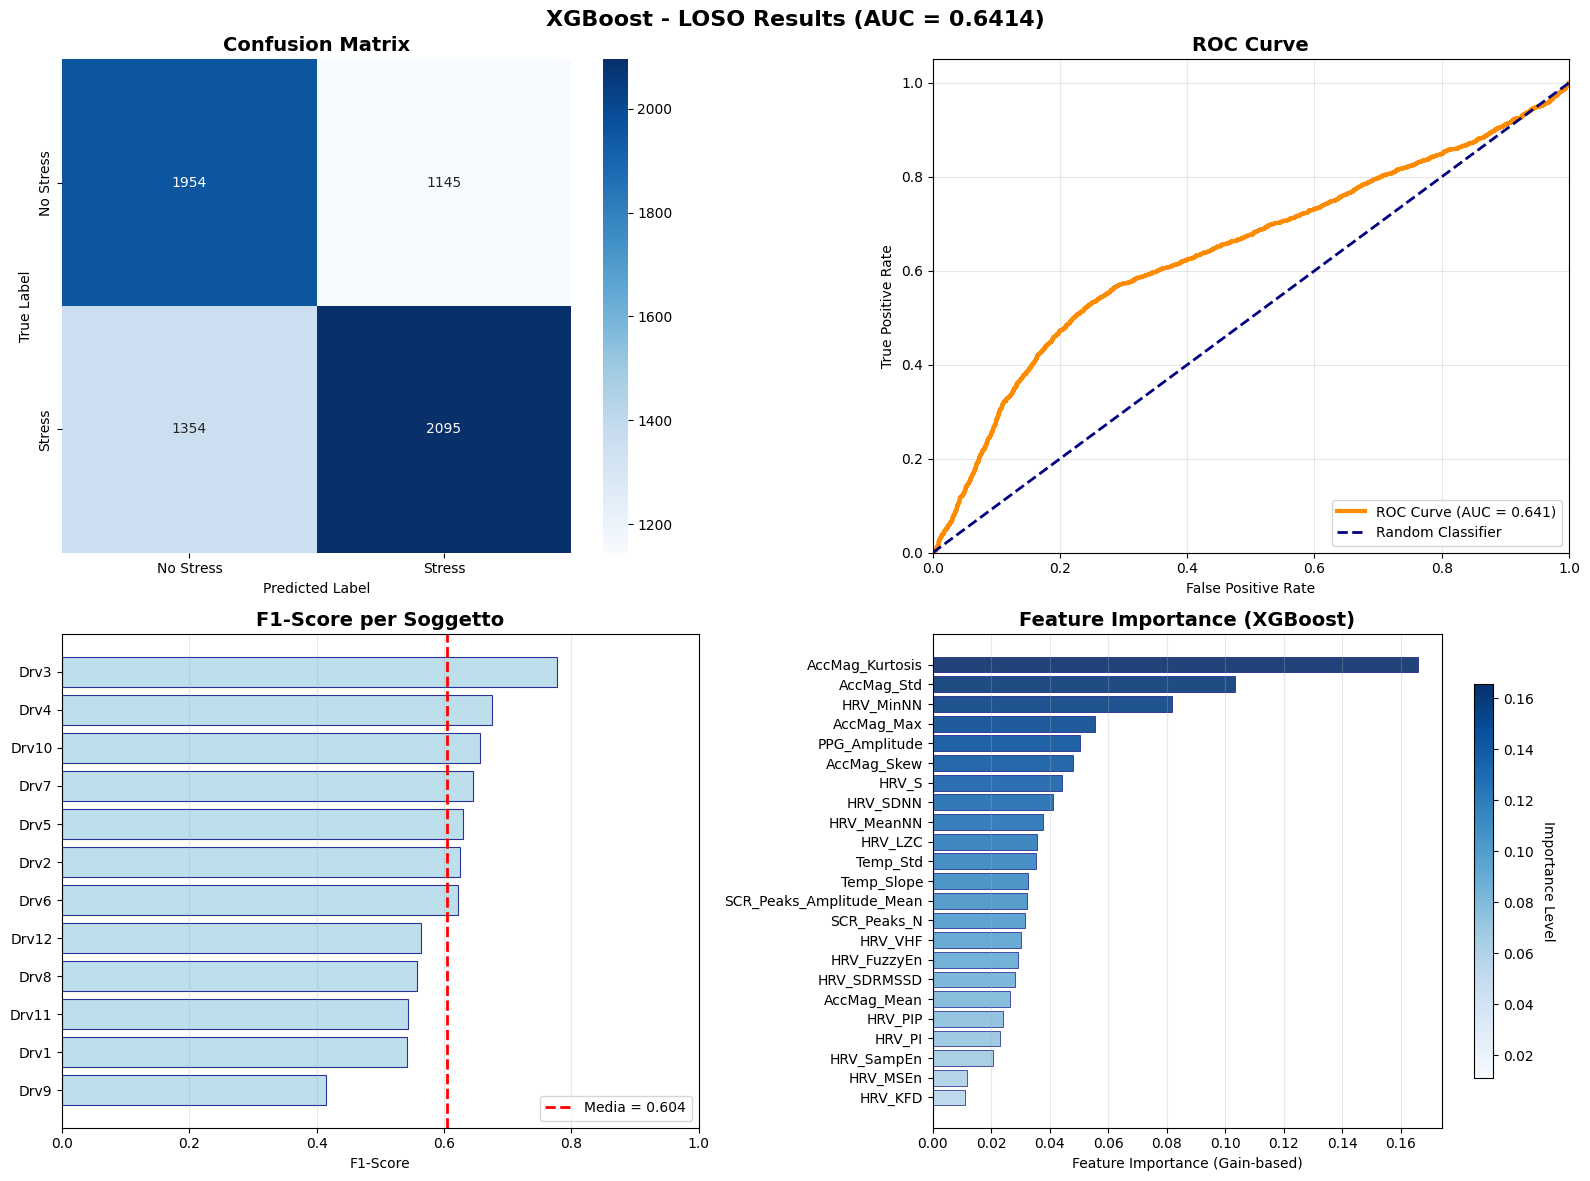


SUMMARY XGBOOST LOSO
Dataset: 12 soggetti, 6548 campioni totali
F1-Score medio: 0.6044 ± 0.0897
AUC globale: 0.6414
Accuratezza globale: 0.6184
Range F1-Score: 0.4146 - 0.7773
Miglior soggetto: Drv3 (F1=0.7773)
Peggiore soggetto: Drv9 (F1=0.4146)

Parametri XGBoost:
N. estimatori: 100
Learning rate: 0.1
Profondità massima: 3
Subsample: 0.8
Colsample bytree: 0.8
Obiettivo: binary:logistic
Booster: None


In [ ]:
# =============================================================================
# LOSO XGBOOST CON VISUALIZZAZIONI COMPLETE
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    accuracy_score, precision_score, recall_score, f1_score
)
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# SETUP DATI E MODELLO
# =============================================================================

# Feature matrix and labels
X = df.drop(columns=['label', 'subject']).values
y = df['label'].values
groups = df['subject'].values

# Estrai nomi delle feature per visualizzazione importance
feature_names = df.drop(columns=["label", "subject"]).columns

# Setup LOSO
logo = LeaveOneGroupOut()

print("=== LOSO XGBOOST ===")
print(f"Samples: {len(X)}, Features: {X.shape[1]}, Subjects: {len(np.unique(groups))}")

# =============================================================================
# CICLO LOSO CON RACCOLTA DATI COMPLETA
# =============================================================================

# Variabili per raccolta risultati
fold_results = []
all_y_true = []
all_y_pred = []
all_y_prob = []
all_subjects = []
final_model = None  # Per feature importance

print("\nInizio valutazione LOSO:")

for fold, (train_idx, test_idx) in enumerate(logo.split(X, y, groups)):
    subject = groups[test_idx[0]]
    print(f"  Fold {fold+1:2d} - {subject:3s}: ", end="")

    # Prepare data
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Skip se una sola classe nel test set
    if len(np.unique(y_test)) < 2:
        print("SKIP (una sola classe)")
        continue

    # Scaling (XGBoost può beneficiare dello scaling)
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Model training
    model = XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric='logloss',
        verbosity=0,
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_train_scaled, y_train)

    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    # Metrics per fold
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"F1={f1:.3f} Acc={acc:.3f}")

    # Store results
    fold_results.append({
        'fold': fold + 1,
        'subject': subject,
        'n_samples': len(y_test),
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1
    })

    # Accumulate global data
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)
    all_y_prob.extend(y_prob)
    all_subjects.extend([subject] * len(y_test))

    # Keep final model for feature importance
    final_model = model

# =============================================================================
# RISULTATI E STATISTICHE
# =============================================================================

print(f"\n{'-'*50}")
print("RISULTATI LOSO")
print(f"{'-'*50}")

# Results per subject
results_df = pd.DataFrame(fold_results)
print("Risultati per soggetto:")
print(results_df[['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score']].to_string(
    index=False, float_format='%.4f'))

# Aggregate statistics
print(f"\nStatistiche aggregate:")
print(f"F1-Score medio:  {results_df['f1_score'].mean():.4f} ± {results_df['f1_score'].std():.4f}")
print(f"Accuracy media:  {results_df['accuracy'].mean():.4f} ± {results_df['accuracy'].std():.4f}")
print(f"Precision media: {results_df['precision'].mean():.4f} ± {results_df['precision'].std():.4f}")
print(f"Recall medio:    {results_df['recall'].mean():.4f} ± {results_df['recall'].std():.4f}")

# Global metrics
print(f"\n{'-'*50}")
print("METRICHE GLOBALI")
print(f"{'-'*50}")

# Convert to numpy arrays
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)
all_y_prob = np.array(all_y_prob)

print("Classification Report Globale:")
print(classification_report(all_y_true, all_y_pred,
                          target_names=['No Stress', 'Stress'],
                          zero_division=0))

# Confusion Matrix
cm_global = confusion_matrix(all_y_true, all_y_pred)
print(f"\nConfusion Matrix Globale:")
print(cm_global)

# ROC AUC
fpr, tpr, _ = roc_curve(all_y_true, all_y_prob)
roc_auc = auc(fpr, tpr)
print(f"AUC Globale: {roc_auc:.4f}")

all_y_true_xgb = np.array(all_y_true).copy()
all_y_pred_xgb = np.array(all_y_pred).copy()
all_y_prob_xgb = np.array(all_y_prob).copy()
fpr_xgb, tpr_xgb, _ = roc_curve(all_y_true_xgb, all_y_prob_xgb)
auc_xgb = auc(fpr_xgb, tpr_xgb)

f1_mean_xgb = results_df['f1_score'].mean()
f1_std_xgb = results_df['f1_score'].std()
acc_mean_xgb = results_df['accuracy'].mean()

# =============================================================================
# VISUALIZZAZIONI COMPLETE (2x2 GRID)
# =============================================================================

print(f"\n{'-'*50}")
print("GENERAZIONE VISUALIZZAZIONI")
print(f"{'-'*50}")

# Setup figura 2x2
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'XGBoost - LOSO Results (AUC = {roc_auc:.4f})',
             fontsize=16, fontweight='bold')

# 1. CONFUSION MATRIX (Top Left) - Palette Blu
sns.heatmap(cm_global, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Stress', 'Stress'],
            yticklabels=['No Stress', 'Stress'],
            ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('True Label')
axes[0,0].set_xlabel('Predicted Label')

# 2. CURVA ROC (Top Right) - Colore Arancione
axes[0,1].plot(fpr, tpr, color='darkorange', lw=3,
               label=f'ROC Curve (AUC = {roc_auc:.3f})')
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
               label='Random Classifier')
axes[0,1].set_xlim([0.0, 1.0])
axes[0,1].set_ylim([0.0, 1.05])
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0,1].legend(loc="lower right")
axes[0,1].grid(True, alpha=0.3)

# 3. F1-SCORE PER SOGGETTO (Bottom Left) - Palette Blu
results_df_sorted = results_df.sort_values('f1_score', ascending=True)
bars = axes[1,0].barh(results_df_sorted['subject'],
                      results_df_sorted['f1_score'],
                      color='lightblue', alpha=0.8, edgecolor='navy', linewidth=0.8)
axes[1,0].set_xlabel('F1-Score')
axes[1,0].set_title('F1-Score per Soggetto', fontsize=14, fontweight='bold')
axes[1,0].grid(True, alpha=0.3, axis='x')

# Aggiungi linea media
mean_f1 = results_df['f1_score'].mean()
axes[1,0].axvline(x=mean_f1, color='red', linestyle='--', linewidth=2,
                  label=f'Media = {mean_f1:.3f}')
axes[1,0].legend()
axes[1,0].set_xlim(0, 1)

# 4. FEATURE IMPORTANCE (Bottom Right) - XGBoost Importance
if final_model is not None:
    # XGBoost ha diversi tipi di importance, usiamo 'weight' (numero di split)
    feature_importance = final_model.feature_importances_

    # Crea DataFrame ordinato per importance
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values(by='importance', ascending=True)

    # Plot con colori graduali basati sull'importanza
    colors = plt.cm.Blues(np.linspace(0.3, 1.0, len(importance_df)))

    bars = axes[1,1].barh(range(len(importance_df)),
                          importance_df['importance'],
                          color=colors, alpha=0.9, edgecolor='navy', linewidth=0.5)

    # Configura assi
    axes[1,1].set_yticks(range(len(importance_df)))
    axes[1,1].set_yticklabels(importance_df['feature'], fontsize=10)
    axes[1,1].set_xlabel('Feature Importance (Gain-based)')
    axes[1,1].set_title('Feature Importance (XGBoost)', fontsize=14, fontweight='bold')
    axes[1,1].grid(True, alpha=0.3, axis='x')

    # Aggiungi colorbar per scala importance
    sm = plt.cm.ScalarMappable(cmap='Blues',
                               norm=plt.Normalize(vmin=importance_df['importance'].min(),
                                                vmax=importance_df['importance'].max()))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=axes[1,1], shrink=0.8)
    cbar.set_label('Importance Level', rotation=270, labelpad=15)

    print(f"Top 5 features più importanti:")
    top_features = importance_df.tail(5)[['feature', 'importance']]
    for _, row in top_features.iterrows():
        print(f"  {row['feature']}: {row['importance']:.4f}")

    # Statistiche feature importance
    print(f"\nStatistiche Feature Importance:")
    print(f"Feature più importante: {importance_df.iloc[-1]['feature']} ({importance_df.iloc[-1]['importance']:.4f})")
    print(f"Importanza media: {feature_importance.mean():.4f}")
    print(f"Features con importanza > media: {np.sum(feature_importance > feature_importance.mean())}")

    # Informazioni aggiuntive XGBoost specifiche
    try:
        # Prova ad ottenere diversi tipi di importance
        importance_types = ['weight', 'gain', 'cover']
        print(f"\nTipi di importance XGBoost disponibili:")
        booster = final_model.get_booster()
        for imp_type in importance_types:
            try:
                importance_dict = booster.get_score(importance_type=imp_type)
                if importance_dict:
                    max_feature = max(importance_dict, key=importance_dict.get)
                    print(f"  {imp_type}: {max_feature} = {importance_dict[max_feature]:.4f}")
            except:
                continue
    except:
        pass

else:
    axes[1,1].text(0.5, 0.5, 'Feature Importance\nNon Disponibile',
                   ha='center', va='center', fontsize=12,
                   transform=axes[1,1].transAxes)
    axes[1,1].set_title('Feature Importance', fontsize=14, fontweight='bold')

# Adjust layout
plt.tight_layout()
plt.show()

# =============================================================================
# SUMMARY FINALE
# =============================================================================

print(f"\n{'='*60}")
print("SUMMARY XGBOOST LOSO")
print(f"{'='*60}")
print(f"Dataset: {len(np.unique(groups))} soggetti, {len(all_y_true)} campioni totali")
print(f"F1-Score medio: {results_df['f1_score'].mean():.4f} ± {results_df['f1_score'].std():.4f}")
print(f"AUC globale: {roc_auc:.4f}")
print(f"Accuratezza globale: {accuracy_score(all_y_true, all_y_pred):.4f}")

# Range performance
print(f"Range F1-Score: {results_df['f1_score'].min():.4f} - {results_df['f1_score'].max():.4f}")
best_subject = results_df.loc[results_df['f1_score'].idxmax(), 'subject']
worst_subject = results_df.loc[results_df['f1_score'].idxmin(), 'subject']
print(f"Miglior soggetto: {best_subject} (F1={results_df['f1_score'].max():.4f})")
print(f"Peggiore soggetto: {worst_subject} (F1={results_df['f1_score'].min():.4f})")

# Informazioni modello XGBoost
if final_model is not None:
    print(f"\nParametri XGBoost:")
    print(f"N. estimatori: {final_model.n_estimators}")
    print(f"Learning rate: {final_model.learning_rate}")
    print(f"Profondità massima: {final_model.max_depth}")
    print(f"Subsample: {final_model.subsample}")
    print(f"Colsample bytree: {final_model.colsample_bytree}")

    # Informazioni training specifiche XGBoost
    try:
        print(f"Obiettivo: {final_model.objective}")
        print(f"Booster: {final_model.booster}")
    except:
        pass

print(f"{'='*60}")

SVM CLASSIFIER

=== LOSO SVM ===
Samples: 6548, Features: 23, Subjects: 12

Inizio valutazione LOSO:
  Fold  1 - Drv1: F1=0.449 Acc=0.623
  Fold  2 - Drv10: F1=0.561 Acc=0.558
  Fold  3 - Drv11: F1=0.641 Acc=0.748
  Fold  4 - Drv12: F1=0.566 Acc=0.646
  Fold  5 - Drv2: F1=0.732 Acc=0.743
  Fold  6 - Drv3: F1=0.741 Acc=0.701
  Fold  7 - Drv4: F1=0.659 Acc=0.664
  Fold  8 - Drv5: F1=0.593 Acc=0.545
  Fold  9 - Drv6: F1=0.675 Acc=0.602
  Fold 10 - Drv7: F1=0.689 Acc=0.673
  Fold 11 - Drv8: F1=0.640 Acc=0.595
  Fold 12 - Drv9: F1=0.571 Acc=0.588

--------------------------------------------------
RISULTATI LOSO
--------------------------------------------------
Risultati per soggetto:
subject  n_samples  accuracy  precision  recall  f1_score
   Drv1        470    0.6234     0.4645  0.4337    0.4486
  Drv10        781    0.5583     0.5301  0.5946    0.5605
  Drv11        619    0.7480     0.5650  0.7394    0.6406
  Drv12        545    0.6459     0.4922  0.6667    0.5663
   Drv2        592    0.7432     0.7

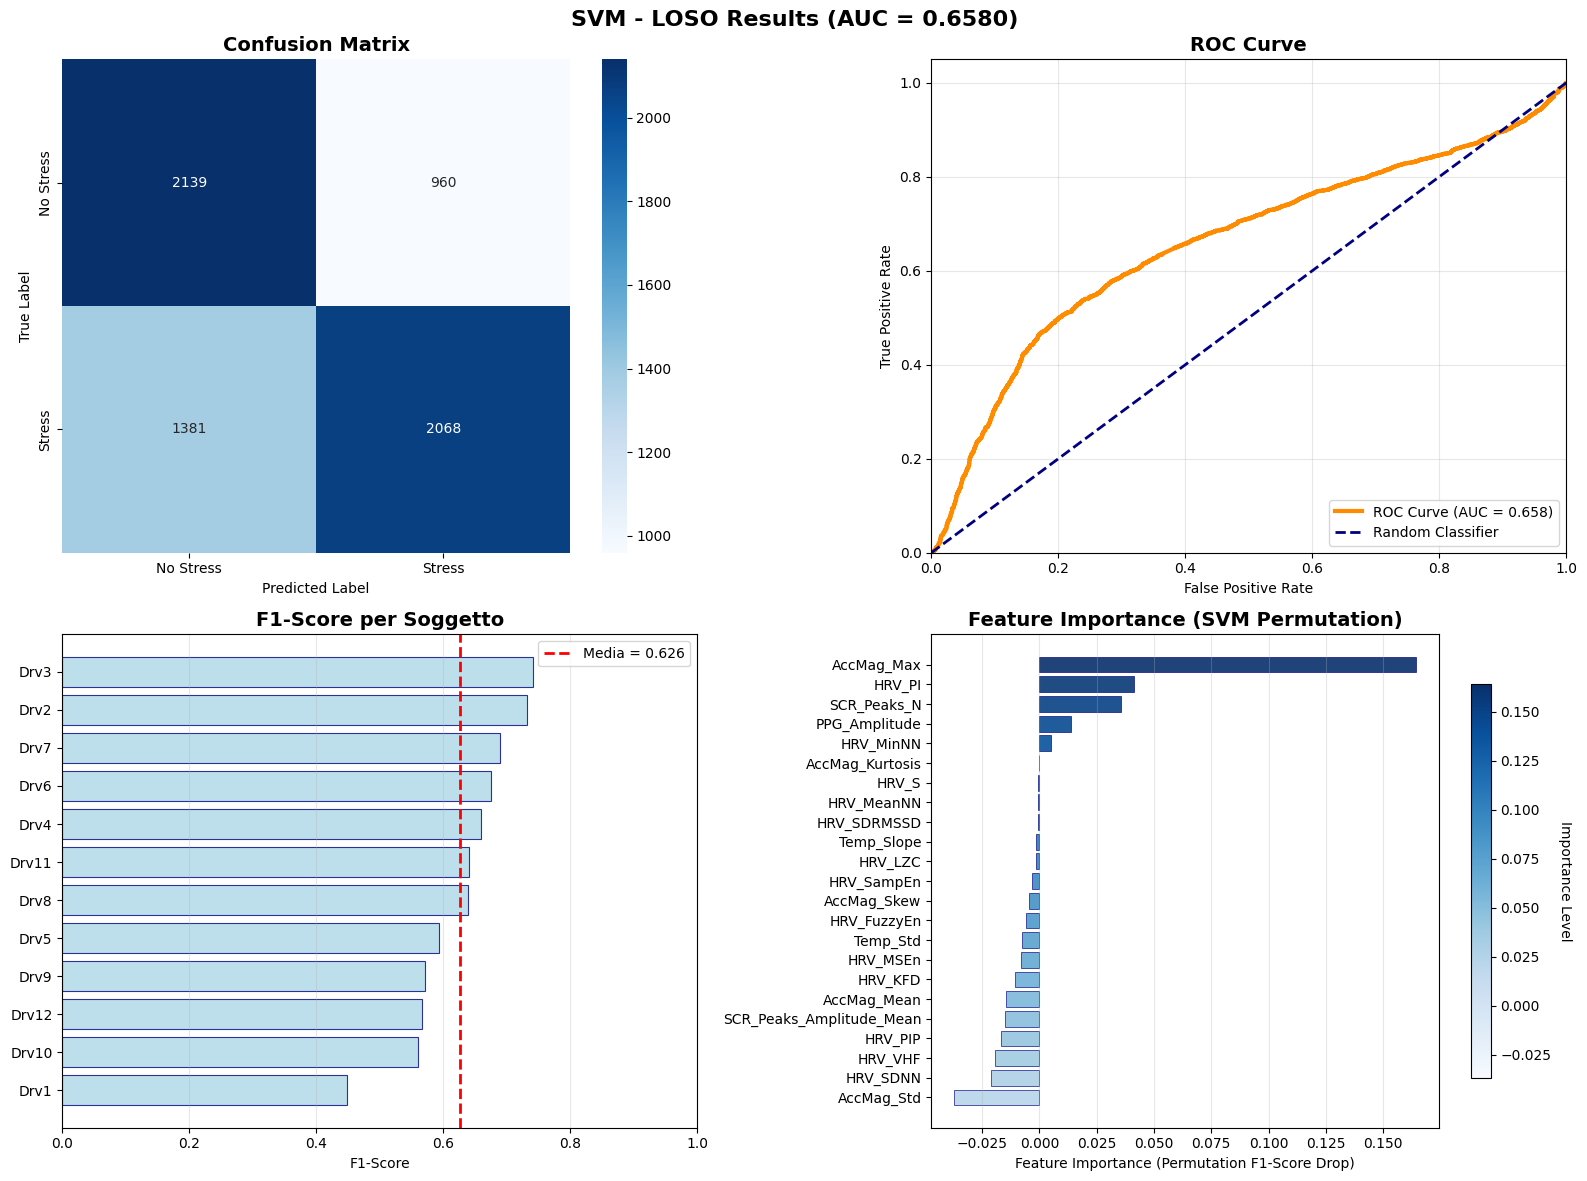


SUMMARY SVM LOSO
Dataset: 12 soggetti, 6548 campioni totali
F1-Score medio: 0.6264 ± 0.0830
AUC globale: 0.6580
Accuratezza globale: 0.6425
Range F1-Score: 0.4486 - 0.7409
Miglior soggetto: Drv3 (F1=0.7409)
Peggiore soggetto: Drv1 (F1=0.4486)

Parametri SVM:
Kernel: rbf
C (regularization): 1.0
Gamma: scale
Class weight: balanced
N. support vectors: [2244 2458]
N. support vectors per classe: {np.int64(0): np.int32(2244), np.int64(1): np.int32(2458)}
Ratio support vectors: 5877.50%


In [ ]:
# =============================================================================
# LOSO SVM CON VISUALIZZAZIONI COMPLETE
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    accuracy_score, precision_score, recall_score, f1_score
)
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# SETUP DATI E MODELLO
# =============================================================================

# Feature matrix and labels
X = df.drop(columns=['label', 'subject']).values
y = df['label'].values
groups = df['subject'].values

# Estrai nomi delle feature per visualizzazione importance
feature_names = df.drop(columns=["label", "subject"]).columns

# Setup LOSO
logo = LeaveOneGroupOut()

print("=== LOSO SVM ===")
print(f"Samples: {len(X)}, Features: {X.shape[1]}, Subjects: {len(np.unique(groups))}")

# =============================================================================
# CICLO LOSO CON RACCOLTA DATI COMPLETA
# =============================================================================

# Variabili per raccolta risultati
fold_results = []
all_y_true = []
all_y_pred = []
all_y_prob = []
all_subjects = []
final_model = None
final_X_test = None  # Per calcolo permutation importance
final_y_test = None

print("\nInizio valutazione LOSO:")

for fold, (train_idx, test_idx) in enumerate(logo.split(X, y, groups)):
    subject = groups[test_idx[0]]
    print(f"  Fold {fold+1:2d} - {subject:3s}: ", end="")

    # Prepare data
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Skip se una sola classe nel test set
    if len(np.unique(y_test)) < 2:
        print("SKIP (una sola classe)")
        continue

    # Scaling (CRITICO per SVM)
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Model training
    model = SVC(
        kernel='rbf',
        C=1.0,
        gamma='scale',
        class_weight='balanced',
        probability=True,  # Necessario per predict_proba
        random_state=42
    )

    model.fit(X_train_scaled, y_train)

    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    # Metrics per fold
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"F1={f1:.3f} Acc={acc:.3f}")

    # Store results
    fold_results.append({
        'fold': fold + 1,
        'subject': subject,
        'n_samples': len(y_test),
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1
    })

    # Accumulate global data
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)
    all_y_prob.extend(y_prob)
    all_subjects.extend([subject] * len(y_test))

    # Keep final model and test data for feature importance
    final_model = model
    final_X_test = X_test_scaled
    final_y_test = y_test

# =============================================================================
# RISULTATI E STATISTICHE
# =============================================================================

print(f"\n{'-'*50}")
print("RISULTATI LOSO")
print(f"{'-'*50}")

# Results per subject
results_df = pd.DataFrame(fold_results)
print("Risultati per soggetto:")
print(results_df[['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score']].to_string(
    index=False, float_format='%.4f'))

# Aggregate statistics
print(f"\nStatistiche aggregate:")
print(f"F1-Score medio:  {results_df['f1_score'].mean():.4f} ± {results_df['f1_score'].std():.4f}")
print(f"Accuracy media:  {results_df['accuracy'].mean():.4f} ± {results_df['accuracy'].std():.4f}")
print(f"Precision media: {results_df['precision'].mean():.4f} ± {results_df['precision'].std():.4f}")
print(f"Recall medio:    {results_df['recall'].mean():.4f} ± {results_df['recall'].std():.4f}")

# Global metrics
print(f"\n{'-'*50}")
print("METRICHE GLOBALI")
print(f"{'-'*50}")

# Convert to numpy arrays
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)
all_y_prob = np.array(all_y_prob)

print("Classification Report Globale:")
print(classification_report(all_y_true, all_y_pred,
                          target_names=['No Stress', 'Stress'],
                          zero_division=0))

# Confusion Matrix
cm_global = confusion_matrix(all_y_true, all_y_pred)
print(f"\nConfusion Matrix Globale:")
print(cm_global)

# ROC AUC
fpr, tpr, _ = roc_curve(all_y_true, all_y_prob)
roc_auc = auc(fpr, tpr)
print(f"AUC Globale: {roc_auc:.4f}")

all_y_true_svm = np.array(all_y_true).copy()
all_y_pred_svm = np.array(all_y_pred).copy()
all_y_prob_svm = np.array(all_y_prob).copy()
fpr_svm, tpr_svm, _ = roc_curve(all_y_true_svm, all_y_prob_svm)
auc_svm = auc(fpr_svm, tpr_svm)

f1_mean_svm = results_df['f1_score'].mean()
f1_std_svm = results_df['f1_score'].std()
acc_mean_svm = results_df['accuracy'].mean()

# =============================================================================
# VISUALIZZAZIONI COMPLETE (2x2 GRID)
# =============================================================================

print(f"\n{'-'*50}")
print("GENERAZIONE VISUALIZZAZIONI")
print(f"{'-'*50}")

# Setup figura 2x2
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'SVM - LOSO Results (AUC = {roc_auc:.4f})',
             fontsize=16, fontweight='bold')

# 1. CONFUSION MATRIX (Top Left) - Palette Blu
sns.heatmap(cm_global, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Stress', 'Stress'],
            yticklabels=['No Stress', 'Stress'],
            ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('True Label')
axes[0,0].set_xlabel('Predicted Label')

# 2. CURVA ROC (Top Right) - Colore Arancione
axes[0,1].plot(fpr, tpr, color='darkorange', lw=3,
               label=f'ROC Curve (AUC = {roc_auc:.3f})')
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
               label='Random Classifier')
axes[0,1].set_xlim([0.0, 1.0])
axes[0,1].set_ylim([0.0, 1.05])
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0,1].legend(loc="lower right")
axes[0,1].grid(True, alpha=0.3)

# 3. F1-SCORE PER SOGGETTO (Bottom Left) - Palette Blu
results_df_sorted = results_df.sort_values('f1_score', ascending=True)
bars = axes[1,0].barh(results_df_sorted['subject'],
                      results_df_sorted['f1_score'],
                      color='lightblue', alpha=0.8, edgecolor='navy', linewidth=0.8)
axes[1,0].set_xlabel('F1-Score')
axes[1,0].set_title('F1-Score per Soggetto', fontsize=14, fontweight='bold')
axes[1,0].grid(True, alpha=0.3, axis='x')

# Aggiungi linea media
mean_f1 = results_df['f1_score'].mean()
axes[1,0].axvline(x=mean_f1, color='red', linestyle='--', linewidth=2,
                  label=f'Media = {mean_f1:.3f}')
axes[1,0].legend()
axes[1,0].set_xlim(0, 1)

# 4. FEATURE IMPORTANCE (Bottom Right) - SVM Permutation Importance
if final_model is not None and final_X_test is not None:
    print("Calcolo permutation importance per SVM...")

    try:
        # Calcola permutation importance (unico metodo disponibile per SVM)
        perm_importance = permutation_importance(
            final_model, final_X_test, final_y_test,
            n_repeats=10, random_state=42, scoring='f1'
        )

        feature_importance = perm_importance.importances_mean

        # Crea DataFrame ordinato per importance
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': feature_importance
        }).sort_values(by='importance', ascending=True)

        # Plot con colori graduali basati sull'importanza
        colors = plt.cm.Blues(np.linspace(0.3, 1.0, len(importance_df)))

        bars = axes[1,1].barh(range(len(importance_df)),
                              importance_df['importance'],
                              color=colors, alpha=0.9, edgecolor='navy', linewidth=0.5)

        # Configura assi
        axes[1,1].set_yticks(range(len(importance_df)))
        axes[1,1].set_yticklabels(importance_df['feature'], fontsize=10)
        axes[1,1].set_xlabel('Feature Importance (Permutation F1-Score Drop)')
        axes[1,1].set_title('Feature Importance (SVM Permutation)', fontsize=14, fontweight='bold')
        axes[1,1].grid(True, alpha=0.3, axis='x')

        # Aggiungi colorbar per scala importance
        sm = plt.cm.ScalarMappable(cmap='Blues',
                                   norm=plt.Normalize(vmin=importance_df['importance'].min(),
                                                    vmax=importance_df['importance'].max()))
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=axes[1,1], shrink=0.8)
        cbar.set_label('Importance Level', rotation=270, labelpad=15)

        print(f"Top 5 features più importanti:")
        top_features = importance_df.tail(5)[['feature', 'importance']]
        for _, row in top_features.iterrows():
            print(f"  {row['feature']}: {row['importance']:.4f}")

        # Statistiche feature importance
        print(f"\nStatistiche Permutation Importance:")
        print(f"Feature più importante: {importance_df.iloc[-1]['feature']} ({importance_df.iloc[-1]['importance']:.4f})")
        print(f"Importanza media: {feature_importance.mean():.4f}")
        print(f"Features con importanza > media: {np.sum(feature_importance > feature_importance.mean())}")

        # Errori standard della permutation importance
        importance_std = perm_importance.importances_std
        print(f"Errore standard medio: {importance_std.mean():.4f}")
        most_stable_idx = np.argmin(importance_std)
        print(f"Feature più stabile: {feature_names[most_stable_idx]} (std={importance_std[most_stable_idx]:.4f})")

    except Exception as e:
        print(f"[ERROR] Calcolo permutation importance fallito: {e}")
        axes[1,1].text(0.5, 0.5, 'Permutation Importance\nCalculation Failed',
                       ha='center', va='center', fontsize=12,
                       transform=axes[1,1].transAxes)
        axes[1,1].set_title('Feature Importance', fontsize=14, fontweight='bold')

else:
    axes[1,1].text(0.5, 0.5, 'Feature Importance\nNon Disponibile',
                   ha='center', va='center', fontsize=12,
                   transform=axes[1,1].transAxes)
    axes[1,1].set_title('Feature Importance', fontsize=14, fontweight='bold')

# Adjust layout
plt.tight_layout()
plt.show()

# =============================================================================
# SUMMARY FINALE
# =============================================================================

print(f"\n{'='*60}")
print("SUMMARY SVM LOSO")
print(f"{'='*60}")
print(f"Dataset: {len(np.unique(groups))} soggetti, {len(all_y_true)} campioni totali")
print(f"F1-Score medio: {results_df['f1_score'].mean():.4f} ± {results_df['f1_score'].std():.4f}")
print(f"AUC globale: {roc_auc:.4f}")
print(f"Accuratezza globale: {accuracy_score(all_y_true, all_y_pred):.4f}")

# Range performance
print(f"Range F1-Score: {results_df['f1_score'].min():.4f} - {results_df['f1_score'].max():.4f}")
best_subject = results_df.loc[results_df['f1_score'].idxmax(), 'subject']
worst_subject = results_df.loc[results_df['f1_score'].idxmin(), 'subject']
print(f"Miglior soggetto: {best_subject} (F1={results_df['f1_score'].max():.4f})")
print(f"Peggiore soggetto: {worst_subject} (F1={results_df['f1_score'].min():.4f})")

# Informazioni modello SVM
if final_model is not None:
    print(f"\nParametri SVM:")
    print(f"Kernel: {final_model.kernel}")
    print(f"C (regularization): {final_model.C}")
    print(f"Gamma: {final_model.gamma}")
    print(f"Class weight: {final_model.class_weight}")

    # Informazioni sui support vectors
    print(f"N. support vectors: {final_model.n_support_}")
    print(f"N. support vectors per classe: {dict(zip(final_model.classes_, final_model.n_support_))}")
    if final_X_test is not None:
        support_vector_ratio = final_model.support_vectors_.shape[0] / len(final_X_test)
        print(f"Ratio support vectors: {support_vector_ratio:.2%}")

print(f"{'='*60}")

MLP

=== LOSO MLP ===
Samples: 6548, Features: 23, Subjects: 12

Inizio valutazione LOSO:
  Fold  1 - Drv1: F1=0.424 Acc=0.687 (8ep)
  Fold  2 - Drv10: F1=0.545 Acc=0.548 (7ep)
  Fold  3 - Drv11: F1=0.629 Acc=0.735 (9ep)
  Fold  4 - Drv12: F1=0.593 Acc=0.703 (7ep)
  Fold  5 - Drv2: F1=0.742 Acc=0.745 (15ep)
  Fold  6 - Drv3: F1=0.755 Acc=0.707 (18ep)
  Fold  7 - Drv4: F1=0.637 Acc=0.604 (8ep)
  Fold  8 - Drv5: F1=0.635 Acc=0.570 (8ep)
  Fold  9 - Drv6: F1=0.701 Acc=0.612 (8ep)
  Fold 10 - Drv7: F1=0.714 Acc=0.685 (12ep)
  Fold 11 - Drv8: F1=0.621 Acc=0.576 (7ep)
  Fold 12 - Drv9: F1=0.650 Acc=0.650 (10ep)

--------------------------------------------------
RISULTATI LOSO
--------------------------------------------------
Risultati per soggetto:
subject  n_samples  accuracy  precision  recall  f1_score  epochs_used
   Drv1        470    0.6872     0.6067  0.3253    0.4235            8
  Drv10        781    0.5480     0.5210  0.5703    0.5445            7
  Drv11        619    0.7351     0.54

Top 5 features più importanti:
  HRV_PIP: 0.0142
  HRV_FuzzyEn: 0.0226
  PPG_Amplitude: 0.0231
  AccMag_Max: 0.0270
  AccMag_Std: 0.1427

Statistiche Permutation Importance:
Feature più importante: AccMag_Std (0.1427)
Importanza media: 0.0115
Features con importanza > media: 7
Errore standard medio: 0.0059
Feature più stabile: Temp_Slope (std=0.0007)


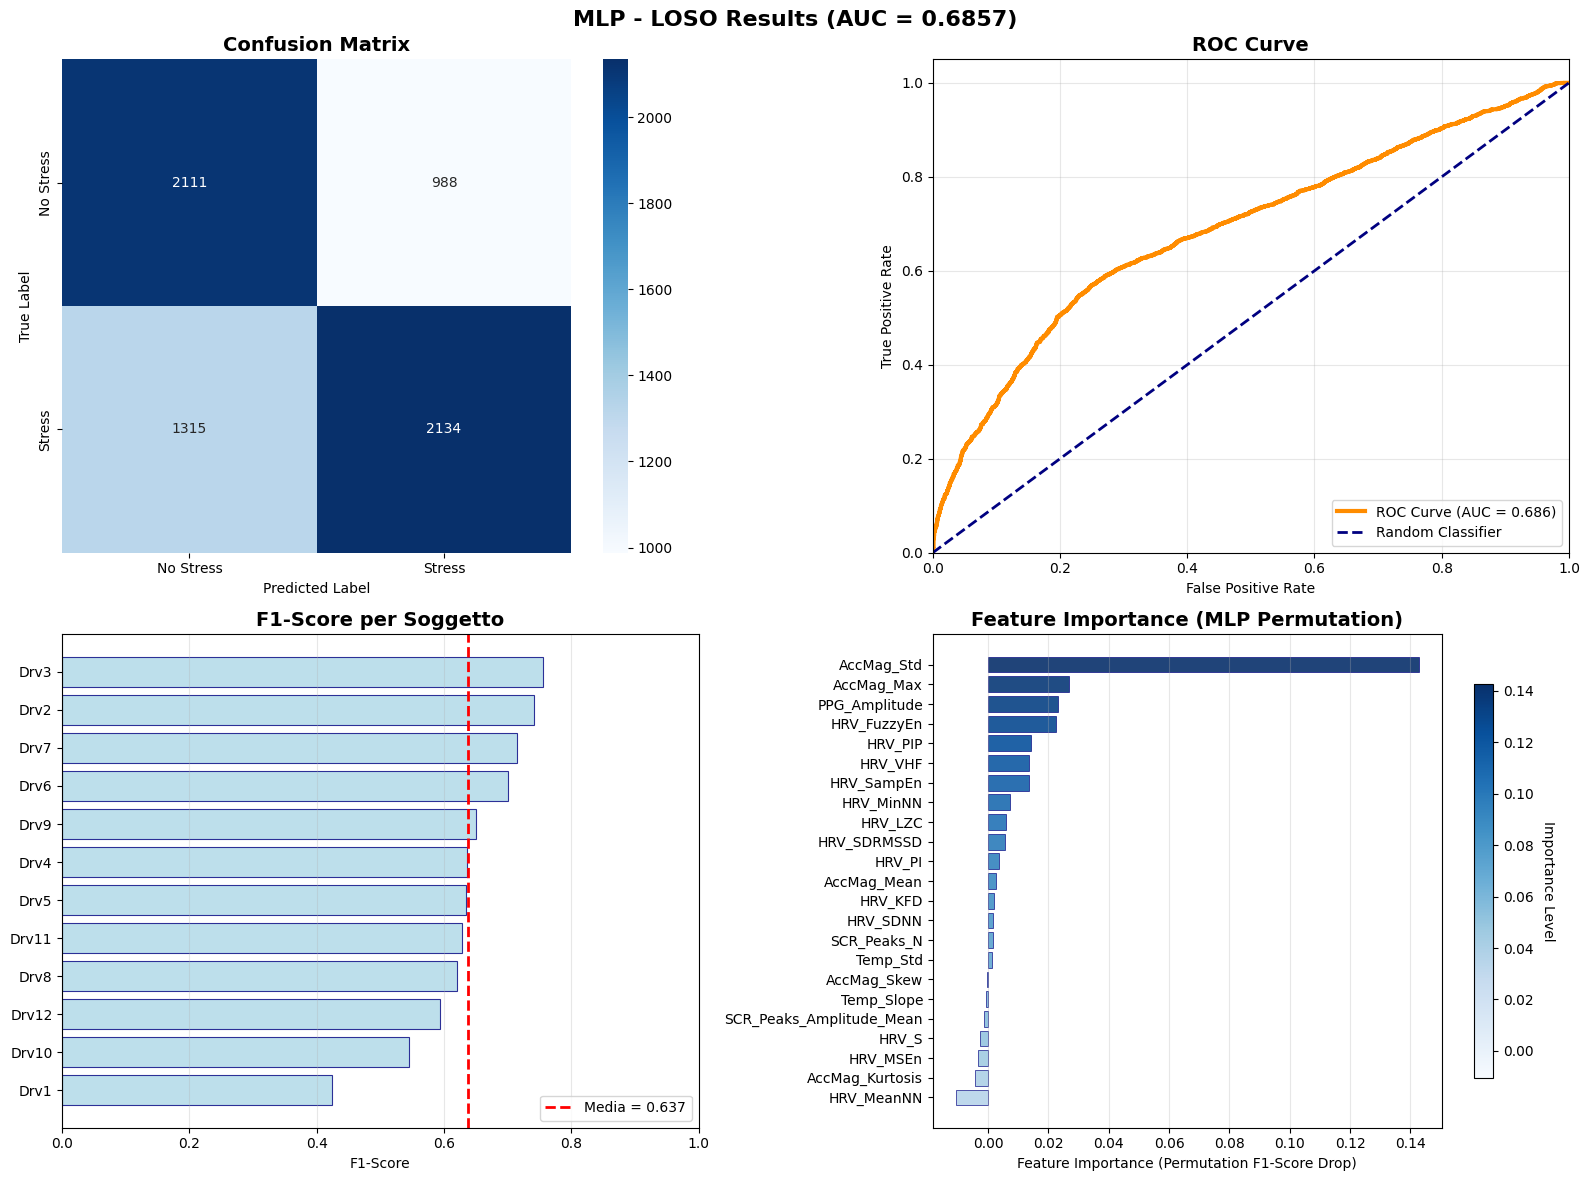


SUMMARY MLP LOSO
Dataset: 12 soggetti, 6548 campioni totali
F1-Score medio: 0.6371 ± 0.0913
AUC globale: 0.6857
Accuratezza globale: 0.6483
Range F1-Score: 0.4235 - 0.7555
Miglior soggetto: Drv3 (F1=0.7555)
Peggiore soggetto: Drv1 (F1=0.4235)
Epoche medie utilizzate: 9.8
Early stopping attivato: 12 / 12 fold


In [ ]:
# =============================================================================
# LOSO MLP CON VISUALIZZAZIONI COMPLETE
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    accuracy_score, precision_score, recall_score, f1_score
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# DEFINIZIONE MODELLO MLP
# =============================================================================

def build_mlp_model(input_dim):
    model = Sequential()
    model.add(Dense(256, input_shape=(input_dim,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.4))

    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.3))

    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.2))

    model.add(Dense(32))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.1))

    model.add(Dense(16))
    model.add(LeakyReLU(alpha=0.1))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# =============================================================================
# SETUP DATI E MODELLO
# =============================================================================

# Feature matrix and labels
X = df.drop(columns=['label', 'subject']).values
y = df['label'].values
groups = df['subject'].values

# Estrai nomi delle feature per visualizzazione importance
feature_names = df.drop(columns=["label", "subject"]).columns

# Setup LOSO
logo = LeaveOneGroupOut()

print("=== LOSO MLP ===")
print(f"Samples: {len(X)}, Features: {X.shape[1]}, Subjects: {len(np.unique(groups))}")

# =============================================================================
# CICLO LOSO CON RACCOLTA DATI
# =============================================================================

# Variabili per raccolta risultati
fold_results = []
all_y_true = []
all_y_pred = []
all_y_prob = []
all_subjects = []
final_model = None  # Per feature importance
final_scaler = None

print("\nInizio valutazione LOSO:")

for fold, (train_idx, test_idx) in enumerate(logo.split(X, y, groups)):
    subject = groups[test_idx[0]]
    print(f"  Fold {fold+1:2d} - {subject:3s}: ", end="")

    # Prepare data
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Skip se una sola classe nel test set
    if len(np.unique(y_test)) < 2:
        print("SKIP (una sola classe)")
        continue

    # Scaling (CRITICO per reti neurali)
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Costruisci modello
    model = build_mlp_model(X_train_scaled.shape[1])

    # Callback per early stopping
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=0
    )

    # Training
    history = model.fit(
        X_train_scaled, y_train,
        validation_data=(X_test_scaled, y_test),
        epochs=30,
        batch_size=32,
        callbacks=[early_stop],
        verbose=0
    )

    # Predictions
    y_prob = model.predict(X_test_scaled, verbose=0).flatten()
    y_pred = (y_prob > 0.5).astype(int)

    # Metrics per fold
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    epochs_used = len(history.history['loss'])
    print(f"F1={f1:.3f} Acc={acc:.3f} ({epochs_used}ep)")

    # Store results
    fold_results.append({
        'fold': fold + 1,
        'subject': subject,
        'n_samples': len(y_test),
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1,
        'epochs_used': epochs_used
    })

    # Accumulate global data
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)
    all_y_prob.extend(y_prob)
    all_subjects.extend([subject] * len(y_test))

    # Keep final model for feature importance
    final_model = tf.keras.models.clone_model(model)
    final_model.set_weights(model.get_weights())
    final_scaler = scaler

    # Pulizia memoria
    del model, history
    tf.keras.backend.clear_session()

# =============================================================================
# RISULTATI E STATISTICHE
# =============================================================================

print(f"\n{'-'*50}")
print("RISULTATI LOSO")
print(f"{'-'*50}")

# Results per subject
results_df = pd.DataFrame(fold_results)
print("Risultati per soggetto:")
print(results_df[['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score', 'epochs_used']].to_string(
    index=False, float_format='%.4f'))

# Aggregate statistics
print(f"\nStatistiche aggregate:")
print(f"F1-Score medio:  {results_df['f1_score'].mean():.4f} ± {results_df['f1_score'].std():.4f}")
print(f"Accuracy media:  {results_df['accuracy'].mean():.4f} ± {results_df['accuracy'].std():.4f}")
print(f"Precision media: {results_df['precision'].mean():.4f} ± {results_df['precision'].std():.4f}")
print(f"Recall medio:    {results_df['recall'].mean():.4f} ± {results_df['recall'].std():.4f}")
print(f"Epoche medie:    {results_df['epochs_used'].mean():.1f}")

# Global metrics
print(f"\n{'-'*50}")
print("METRICHE GLOBALI")
print(f"{'-'*50}")

# Convert to numpy arrays
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)
all_y_prob = np.array(all_y_prob)

print("Classification Report Globale:")
print(classification_report(all_y_true, all_y_pred,
                          target_names=['No Stress', 'Stress'],
                          zero_division=0))

# Confusion Matrix
cm_global = confusion_matrix(all_y_true, all_y_pred)
print(f"\nConfusion Matrix Globale:")
print(cm_global)

# ROC AUC
fpr, tpr, _ = roc_curve(all_y_true, all_y_prob)
roc_auc = auc(fpr, tpr)
print(f"AUC Globale: {roc_auc:.4f}")

all_y_true_mlp = np.array(all_y_true).copy()
all_y_pred_mlp = np.array(all_y_pred).copy()
all_y_prob_mlp = np.array(all_y_prob).copy()
fpr_mlp, tpr_mlp, _ = roc_curve(all_y_true_mlp, all_y_prob_mlp)
auc_mlp = auc(fpr_mlp, tpr_mlp)

f1_mean_mlp = results_df['f1_score'].mean()
f1_std_mlp = results_df['f1_score'].std()
acc_mean_mlp = results_df['accuracy'].mean()

# =============================================================================
# VISUALIZZAZIONI COMPLETE (2x2 GRID)
# =============================================================================

print(f"\n{'-'*50}")
print("GENERAZIONE VISUALIZZAZIONI")
print(f"{'-'*50}")

# Setup figura 2x2
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'MLP - LOSO Results (AUC = {roc_auc:.4f})',
             fontsize=16, fontweight='bold')

# 1. CONFUSION MATRIX (Top Left) - Palette Blu
sns.heatmap(cm_global, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Stress', 'Stress'],
            yticklabels=['No Stress', 'Stress'],
            ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('True Label')
axes[0,0].set_xlabel('Predicted Label')

# 2. CURVA ROC (Top Right) - Colore Arancione
axes[0,1].plot(fpr, tpr, color='darkorange', lw=3,
               label=f'ROC Curve (AUC = {roc_auc:.3f})')
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
               label='Random Classifier')
axes[0,1].set_xlim([0.0, 1.0])
axes[0,1].set_ylim([0.0, 1.05])
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0,1].legend(loc="lower right")
axes[0,1].grid(True, alpha=0.3)

# 3. F1-SCORE PER SOGGETTO (Bottom Left) - Palette Blu
results_df_sorted = results_df.sort_values('f1_score', ascending=True)
bars = axes[1,0].barh(results_df_sorted['subject'],
                      results_df_sorted['f1_score'],
                      color='lightblue', alpha=0.8, edgecolor='navy', linewidth=0.8)
axes[1,0].set_xlabel('F1-Score')
axes[1,0].set_title('F1-Score per Soggetto', fontsize=14, fontweight='bold')
axes[1,0].grid(True, alpha=0.3, axis='x')

# Aggiungi linea media
mean_f1 = results_df['f1_score'].mean()
axes[1,0].axvline(x=mean_f1, color='red', linestyle='--', linewidth=2,
                  label=f'Media = {mean_f1:.3f}')
axes[1,0].legend()
axes[1,0].set_xlim(0, 1)

# 4. FEATURE IMPORTANCE (Bottom Right) - MLP Permutation Importance
if final_model is not None:
    print("Calcolo permutation importance per MLP...")

    try:
        # Prepara dati per permutation importance
        # Usa un subset rappresentativo per velocità
        sample_size = min(500, len(all_y_true))
        sample_indices = np.random.choice(len(all_y_true), sample_size, replace=False)

        X_sample = np.array([X[i] for i in sample_indices])
        y_sample = np.array([all_y_true[i] for i in sample_indices])

        # Normalizza con final_scaler
        X_sample_scaled = final_scaler.transform(X_sample)

        # Wrapper class per sklearn compatibility
        class MLPWrapper:
            def __init__(self, model):
                self.model = model

            def fit(self, X, y):
                return self  # Dummy fit

            def predict(self, X):
                return (self.model.predict(X, verbose=0) > 0.5).astype(int).flatten()

            def score(self, X, y):
                y_pred = self.predict(X)
                return f1_score(y, y_pred, zero_division=0)

        # Crea wrapper
        mlp_wrapper = MLPWrapper(final_model)

        # Calcola permutation importance
        perm_importance = permutation_importance(
            mlp_wrapper, X_sample_scaled, y_sample,
            n_repeats=5,  # Ridotto per velocità
            random_state=42,
            scoring='f1'
        )

        feature_importance = perm_importance.importances_mean

        # Crea DataFrame ordinato per importance
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': feature_importance
        }).sort_values(by='importance', ascending=True)

        # Plot con colori graduali basati sull'importanza
        colors = plt.cm.Blues(np.linspace(0.3, 1.0, len(importance_df)))

        bars = axes[1,1].barh(range(len(importance_df)),
                              importance_df['importance'],
                              color=colors, alpha=0.9, edgecolor='navy', linewidth=0.5)

        # Configura assi
        axes[1,1].set_yticks(range(len(importance_df)))
        axes[1,1].set_yticklabels(importance_df['feature'], fontsize=10)
        axes[1,1].set_xlabel('Feature Importance (Permutation F1-Score Drop)')
        axes[1,1].set_title('Feature Importance (MLP Permutation)', fontsize=14, fontweight='bold')
        axes[1,1].grid(True, alpha=0.3, axis='x')

        # Aggiungi colorbar per scala importance
        sm = plt.cm.ScalarMappable(cmap='Blues',
                                   norm=plt.Normalize(vmin=importance_df['importance'].min(),
                                                    vmax=importance_df['importance'].max()))
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=axes[1,1], shrink=0.8)
        cbar.set_label('Importance Level', rotation=270, labelpad=15)

        print(f"Top 5 features più importanti:")
        top_features = importance_df.tail(5)[['feature', 'importance']]
        for _, row in top_features.iterrows():
            print(f"  {row['feature']}: {row['importance']:.4f}")

        # Statistiche feature importance
        print(f"\nStatistiche Permutation Importance:")
        print(f"Feature più importante: {importance_df.iloc[-1]['feature']} ({importance_df.iloc[-1]['importance']:.4f})")
        print(f"Importanza media: {feature_importance.mean():.4f}")
        print(f"Features con importanza > media: {np.sum(feature_importance > feature_importance.mean())}")

        # Errori standard della permutation importance
        importance_std = perm_importance.importances_std
        print(f"Errore standard medio: {importance_std.mean():.4f}")
        most_stable_idx = np.argmin(importance_std)
        print(f"Feature più stabile: {feature_names[most_stable_idx]} (std={importance_std[most_stable_idx]:.4f})")

    except Exception as e:
        print(f"[ERROR] Calcolo permutation importance fallito: {e}")
        axes[1,1].text(0.5, 0.5, 'Permutation Importance\nCalculation Failed\n(Computationally expensive)',
                       ha='center', va='center', fontsize=11,
                       transform=axes[1,1].transAxes)
        axes[1,1].set_title('Feature Importance', fontsize=14, fontweight='bold')

else:
    axes[1,1].text(0.5, 0.5, 'Feature Importance\nNon Disponibile',
                   ha='center', va='center', fontsize=12,
                   transform=axes[1,1].transAxes)
    axes[1,1].set_title('Feature Importance', fontsize=14, fontweight='bold')

# Adjust layout
plt.tight_layout()
plt.show()

# =============================================================================
# SUMMARY FINALE
# =============================================================================

print(f"\n{'='*60}")
print("SUMMARY MLP LOSO")
print(f"{'='*60}")
print(f"Dataset: {len(np.unique(groups))} soggetti, {len(all_y_true)} campioni totali")
print(f"F1-Score medio: {results_df['f1_score'].mean():.4f} ± {results_df['f1_score'].std():.4f}")
print(f"AUC globale: {roc_auc:.4f}")
print(f"Accuratezza globale: {accuracy_score(all_y_true, all_y_pred):.4f}")

# Range performance
print(f"Range F1-Score: {results_df['f1_score'].min():.4f} - {results_df['f1_score'].max():.4f}")
best_subject_result = results_df.loc[results_df['f1_score'].idxmax(), 'subject']
worst_subject_result = results_df.loc[results_df['f1_score'].idxmin(), 'subject']
print(f"Miglior soggetto: {best_subject_result} (F1={results_df['f1_score'].max():.4f})")
print(f"Peggiore soggetto: {worst_subject_result} (F1={results_df['f1_score'].min():.4f})")

# Informazioni training
print(f"Epoche medie utilizzate: {results_df['epochs_used'].mean():.1f}")
print(f"Early stopping attivato: {np.sum(results_df['epochs_used'] < 30)} / {len(results_df)} fold")

print(f"{'='*60}")


CONFRONTO CURVE ROC - TUTTI I MODELLI ML/DL SU DATASET AFFECTIVE ROAD
[OK] Logistic Regression       - Risultati disponibili
[OK] Random Forest             - Risultati disponibili
[OK] Gradient Boosting         - Risultati disponibili
[OK] XGBoost                   - Risultati disponibili
[OK] SVM                       - Risultati disponibili
[OK] MLP                       - Risultati disponibili

[OK] Proseguo con il confronto di 6 modelli



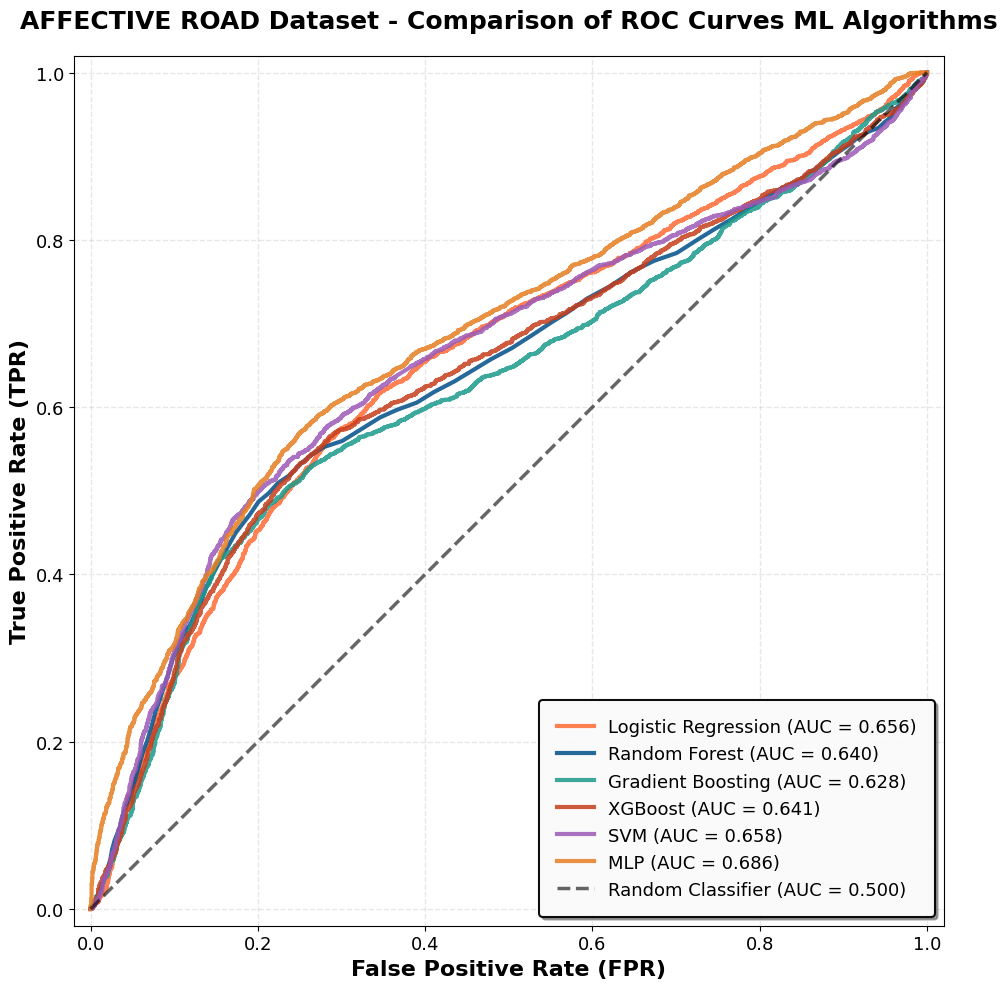


TABELLA RIASSUNTIVA - AUC SCORE PER MODELLO

 Rank             Modello    AUC
    1                 MLP 0.6857
    2                 SVM 0.6580
    3 Logistic Regression 0.6555
    4             XGBoost 0.6414
    5       Random Forest 0.6403
    6   Gradient Boosting 0.6277


MIGLIOR MODELLO: MLP
AUC Score: 0.6857

STATISTICHE AUC SU 6 MODELLI:
Media:    0.6514
Mediana:  0.6485
Std Dev:  0.0201
Range:    [0.6277, 0.6857]
Gap:      0.0580

RANKING FINALE:
   1. MLP                       - AUC: 0.6857
   2. SVM                       - AUC: 0.6580
   3. Logistic Regression       - AUC: 0.6555
   4. XGBoost                   - AUC: 0.6414
   5. Random Forest             - AUC: 0.6403
   6. Gradient Boosting         - AUC: 0.6277

GAP ANALYSIS:
   Gap 1-2: 0.0276 (2.76%)
   Gap 2-3: 0.0025 (0.25%)
   Gap 3-4: 0.0141 (1.41%)

CATEGORIZZAZIONE PERFORMANCE:
   Poor (AUC < 0.7): 6 modelli
      - MLP (AUC = 0.6857)
      - SVM (AUC = 0.6580)
      - Logistic Regression (AUC = 0.6555)
      - 

In [ ]:
# =============================================================================
# CONFRONTO CURVE ROC - TUTTI I MODELLI ML/DL
# =============================================================================

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
import pandas as pd

print("\n" + "="*80)
print("CONFRONTO CURVE ROC - TUTTI I MODELLI ML/DL SU DATASET AFFECTIVE ROAD")
print("="*80)

# =============================================================================
# VERIFICA DISPONIBILITA RISULTATI
# =============================================================================

required_vars = {
    'Logistic Regression': ('fpr_lr', 'tpr_lr', 'auc_lr'),
    'Random Forest': ('fpr_rf', 'tpr_rf', 'auc_rf'),
    'Gradient Boosting': ('fpr_gb', 'tpr_gb', 'auc_gb'),
    'XGBoost': ('fpr_xgb', 'tpr_xgb', 'auc_xgb'),
    'SVM': ('fpr_svm', 'tpr_svm', 'auc_svm'),
    'MLP': ('fpr_mlp', 'tpr_mlp', 'auc_mlp')
}

available_models = []
missing_models = []

for model_name, (fpr_var, tpr_var, auc_var) in required_vars.items():
    if fpr_var in globals() and tpr_var in globals() and auc_var in globals():
        available_models.append(model_name)
        print(f"[OK] {model_name:25s} - Risultati disponibili")
    else:
        missing_models.append(model_name)
        print(f"[NO] {model_name:25s} - Risultati NON disponibili")

if missing_models:
    print(f"\n[WARNING] {len(missing_models)} modelli mancanti!")
    print("          Esegui prima le sezioni LOSO di tutti i modelli.")

if len(available_models) < 2:
    print("\n[ERROR] Servono almeno 2 modelli per il confronto!")
else:
    print(f"\n[OK] Proseguo con il confronto di {len(available_models)} modelli\n")

    # =============================================================================
    # PLOT: CURVE ROC SOVRAPPOSTE (FIGURA QUADRATA)
    # =============================================================================

    fig, ax = plt.subplots(figsize=(10, 10))

    # Definisci configurazione per ogni modello
    models_config = [
        ('Logistic Regression', fpr_lr if 'fpr_lr' in globals() else None,
         tpr_lr if 'tpr_lr' in globals() else None,
         auc_lr if 'auc_lr' in globals() else None, '#FF6B35'),
        ('Random Forest', fpr_rf if 'fpr_rf' in globals() else None,
         tpr_rf if 'tpr_rf' in globals() else None,
         auc_rf if 'auc_rf' in globals() else None, '#004E89'),
        ('Gradient Boosting', fpr_gb if 'fpr_gb' in globals() else None,
         tpr_gb if 'tpr_gb' in globals() else None,
         auc_gb if 'auc_gb' in globals() else None, '#1B998B'),
        ('XGBoost', fpr_xgb if 'fpr_xgb' in globals() else None,
         tpr_xgb if 'tpr_xgb' in globals() else None,
         auc_xgb if 'auc_xgb' in globals() else None, '#C73E1D'),
        ('SVM', fpr_svm if 'fpr_svm' in globals() else None,
         tpr_svm if 'tpr_svm' in globals() else None,
         auc_svm if 'auc_svm' in globals() else None, '#9B59B6'),
        ('MLP', fpr_mlp if 'fpr_mlp' in globals() else None,
         tpr_mlp if 'tpr_mlp' in globals() else None,
         auc_mlp if 'auc_mlp' in globals() else None, '#E67E22')
    ]

    # Plot curve ROC per ogni modello disponibile
    for model_name, fpr, tpr, auc_score, color in models_config:
        if fpr is not None and tpr is not None and auc_score is not None:
            ax.plot(fpr, tpr,
                    color=color,
                    linewidth=3,
                    alpha=0.85,
                    label=f'{model_name} (AUC = {auc_score:.3f})')

    # Plot linea random classifier
    ax.plot([0, 1], [0, 1],
            'k--',
            linewidth=2.5,
            label='Random Classifier (AUC = 0.500)',
            alpha=0.6)

    # Configurazione assi e titolo
    ax.set_xlabel('False Positive Rate (FPR)', fontsize=16, fontweight='bold')
    ax.set_ylabel('True Positive Rate (TPR)', fontsize=16, fontweight='bold')
    ax.set_title('AFFECTIVE ROAD Dataset - Comparison of ROC Curves ML Algorithms',
                 fontsize=18, fontweight='bold', pad=20)

    # Grid e limiti
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=1)
    ax.set_xlim([-0.02, 1.02])
    ax.set_ylim([-0.02, 1.02])
    ax.set_aspect('equal')

    # Legenda con box shadow
    legend = ax.legend(loc='lower right',
                      fontsize=13,
                      framealpha=0.95,
                      shadow=True,
                      fancybox=True,
                      borderpad=1)
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_edgecolor('black')
    legend.get_frame().set_linewidth(1.5)

    # Tick più grandi
    ax.tick_params(labelsize=13)

    # Layout e visualizzazione
    plt.tight_layout()
    plt.show()

    # =============================================================================
    # TABELLA RIASSUNTIVA
    # =============================================================================

    print("\n" + "="*80)
    print("TABELLA RIASSUNTIVA - AUC SCORE PER MODELLO")
    print("="*80 + "\n")

    # Raccogli dati AUC disponibili
    comparison_data = []
    if 'auc_lr' in globals():
        comparison_data.append({'Modello': 'Logistic Regression', 'AUC': auc_lr})
    if 'auc_rf' in globals():
        comparison_data.append({'Modello': 'Random Forest', 'AUC': auc_rf})
    if 'auc_gb' in globals():
        comparison_data.append({'Modello': 'Gradient Boosting', 'AUC': auc_gb})
    if 'auc_xgb' in globals():
        comparison_data.append({'Modello': 'XGBoost', 'AUC': auc_xgb})
    if 'auc_svm' in globals():
        comparison_data.append({'Modello': 'SVM', 'AUC': auc_svm})
    if 'auc_mlp' in globals():
        comparison_data.append({'Modello': 'MLP', 'AUC': auc_mlp})

    # Crea DataFrame e ordina per AUC
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('AUC', ascending=False).reset_index(drop=True)
    comparison_df['Rank'] = range(1, len(comparison_df) + 1)

    # Stampa tabella
    print(comparison_df[['Rank', 'Modello', 'AUC']].to_string(
        index=False,
        float_format=lambda x: f'{x:.4f}'))
    print("\n" + "="*80)

    # Identifica miglior modello
    best_model = comparison_df.iloc[0]
    print(f"\nMIGLIOR MODELLO: {best_model['Modello']}")
    print(f"AUC Score: {best_model['AUC']:.4f}")

    # Statistiche aggregate
    print(f"\nSTATISTICHE AUC SU {len(comparison_df)} MODELLI:")
    print(f"Media:    {comparison_df['AUC'].mean():.4f}")
    print(f"Mediana:  {comparison_df['AUC'].median():.4f}")
    print(f"Std Dev:  {comparison_df['AUC'].std():.4f}")
    print(f"Range:    [{comparison_df['AUC'].min():.4f}, {comparison_df['AUC'].max():.4f}]")
    print(f"Gap:      {comparison_df['AUC'].max() - comparison_df['AUC'].min():.4f}")

    # Ranking
    print(f"\nRANKING FINALE:")
    for idx, row in comparison_df.iterrows():
        print(f"   {idx+1}. {row['Modello']:25s} - AUC: {row['AUC']:.4f}")

    # Gap analysis
    if len(comparison_df) >= 2:
        print(f"\nGAP ANALYSIS:")
        for i in range(min(3, len(comparison_df) - 1)):
            gap = comparison_df.iloc[i]['AUC'] - comparison_df.iloc[i+1]['AUC']
            print(f"   Gap {i+1}-{i+2}: {gap:.4f} ({gap*100:.2f}%)")

    # Categorizzazione performance
    print(f"\nCATEGORIZZAZIONE PERFORMANCE:")
    excellent = comparison_df[comparison_df['AUC'] >= 0.9]
    good = comparison_df[(comparison_df['AUC'] >= 0.8) & (comparison_df['AUC'] < 0.9)]
    fair = comparison_df[(comparison_df['AUC'] >= 0.7) & (comparison_df['AUC'] < 0.8)]
    poor = comparison_df[comparison_df['AUC'] < 0.7]

    if len(excellent) > 0:
        print(f"   Excellent (AUC >= 0.9): {len(excellent)} modelli")
        for _, row in excellent.iterrows():
            print(f"      - {row['Modello']} (AUC = {row['AUC']:.4f})")

    if len(good) > 0:
        print(f"   Good (0.8 <= AUC < 0.9): {len(good)} modelli")
        for _, row in good.iterrows():
            print(f"      - {row['Modello']} (AUC = {row['AUC']:.4f})")

    if len(fair) > 0:
        print(f"   Fair (0.7 <= AUC < 0.8): {len(fair)} modelli")
        for _, row in fair.iterrows():
            print(f"      - {row['Modello']} (AUC = {row['AUC']:.4f})")

    if len(poor) > 0:
        print(f"   Poor (AUC < 0.7): {len(poor)} modelli")
        for _, row in poor.iterrows():
            print(f"      - {row['Modello']} (AUC = {row['AUC']:.4f})")

    print("\n" + "="*80)
    print("ANALISI COMPARATIVA COMPLETATA")
    print("="*80 + "\n")